# Init

In [32]:
"""
Pip update helper
"""

# Works also without IPython:
import json, subprocess
pip_o = json.loads(subprocess.run(["pip", "list", "-o", "--format", "json"], capture_output = True).stdout)

# # Works only with IPython:
# pip_o = !pip list -o --format=json
# pip_o = json.loads(pip_o[0])

for i, o in enumerate(pip_o):
    print(f'{i:2}) {o["name"]:25}: {o["version"]:12} ->   {o["latest_version"]}')
choice = input("which to update? (eg. \"0 1 22 30\")")
print("updating:", *[pip_o[int(x)]["name"] for x in choice.split()])

# subprocess.run(["pip", "install", "-U"] + [pip_o[int(x)]["name"] for x in choice.split()])
# %pip install -U {" ".join([pip_o[int(x)]["name"] for x in choice.split()])}

In [ ]:
# %pip install -U pip streamlit numpy pandas scipy
%pip install -U dask[complete] dask-ml dtale 
# xgboost # https://pypi.org/project/xgboost/ # https://xgboost.readthedocs.io/en/latest/tutorials/dask.html
# %pip install -U graphviz
# %pip install pandasgui dtale pandas-profiling[notebook]

In [ ]:
import json
import pathlib
import time
from os import PathLike
from pathlib import Path
from pprint import pprint
from typing import List, Optional, Union

import dask
import dask.dataframe as dd
import dask_ml
import dask_ml.cluster
# import dask_ml.compose
# import dask_ml.decomposition
# import dask_ml.ensemble
# import dask_ml.feature_extraction
import dask_ml.impute
# import dask_ml.linear_model
# import dask_ml.preprocessing
# import dask_ml.xgboost
import dtale
import ipywidgets as widgets
import lxml
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas.testing
import pandas_profiling
import pandasgui
import scipy
import seaborn as sns
import streamlit as st
import xarray as xr
from IPython.core.display import HTML
from pandas import DataFrame
from pandas_profiling import ProfileReport

from data_challenges.data import (PATHs, derive_data, load_challenge_data,
                                  load_data_set, prep_csv_merge, rearrange_df,
                                  sample_patients)
from data_challenges.helper import is_ipython

%matplotlib inline

In [2]:
"""
Pandas settings
"""

# pd.set_option("display.max_rows", 200)
pd.options.display.max_columns = 50
# pd.options.display.precision = 6

# overwrite the df _repr_html_ to render nan values as "܁"
if not hasattr(pd.DataFrame, "__repr_html_bak"):
    # https://github.com/pandas-dev/pandas/blob/2e29e1172bb5d17c5d6f4d8bec1d3e6452091822/pandas/core/frame.py#L1001
    pd.DataFrame.__repr_html_bak = pd.DataFrame._repr_html_
def df_html_no_nan(self):
    # ·⸱⸱܁ ▉ # https://www.compart.com/de/unicode/U+0701 # https://en.wikipedia.org/wiki/Box-drawing_character
    # self = self.fillna("܁")  # fillna("܁") can sometimes produce errors
    html = pd.DataFrame.__repr_html_bak(self)
    # return html
    return html.replace("<td>NaN</td>", "<td>܁</td>").replace(r"<td>&lt;NA&gt;</td>", "<td>܁</td>")
    return html.replace("NaN", "܁").replace("<NA>", "܁")
pd.DataFrame._repr_html_ = df_html_no_nan


def df_auto_style(self,
                  precision: Optional[int] = None,
                  na_rep: Optional[str] = "܁",
                  thousands: Optional[str] = ",",
                  subset = None,
                  ):
    # self.reset_index(inplace = True)
    # style = DataFrame([[True, False], [1,2,5], [1e-5, 1e-12, 1e-22], [np.pi, np.pi * 1e-3, np.pi * 1e-6], [1e22, 1e-22], [None, np.nan], ["text", "lol"]]).T \
    style = self.style.background_gradient(
            subset = subset,
        ).bar(
            subset = subset,
        ).highlight_null(
            subset = subset,
        ).set_properties(
            subset = subset,
            **{
                # "border-style": "solid", "border-color": "black",
                # "background-color": "lightgrey",
            }
        # ).set_table_styles(
        #     [
        #         {'selector': 'th', 'props': [('font-size', '10pt')]},
        #         {'selector': 'td', 'props': [('font-size', '10pt')]},
        #         {'selector': 'table', 'props': [('border-style', 'solid')]},
        #         {'selector': 'th', 'props': [('border-style', 'solid')]},
        #         {'selector': 'td', 'props': [('border-style', 'solid')]},
        #     ]
        # ).format(
        #     na_rep = na_rep,
        #     thousands = thousands,
        #     precision = precision
        ).export()
    return self.style.use(style).format(
            na_rep = na_rep,
            thousands = thousands,
            precision = precision,
            subset = subset,
        ).apply(
            lambda s: ["color: green; background-color: rgba(0,255,0,0.05);" if x is True else "color: red; background-color: rgba(255,0,0,0.2)" if x is False else "" for x in s],
            subset = subset,
        )
# if hasattr(pd.DataFrame, "style_auto"):
#     raise Exception("style_auto already exists")
# else:
if not hasattr(pd.DataFrame, "style_auto") or input("Do you want to overwrite the method style_auto? (y/n):") == "y":
    pd.DataFrame.style_auto = df_auto_style


"""
plotting settings
"""

# sns.set_theme(context = "notebook", style = "darkgrid")  # https://seaborn.pydata.org/generated/seaborn.set_theme.html
# sns.set_style("whitegrid")  # https://seaborn.pydata.org/generated/seaborn.set_style.html
sns.set_style("darkgrid")  # https://seaborn.pydata.org/generated/seaborn.set_style.html
# sns.reset_orig()  # sns.reset_defaults()

In [5]:
# %pprint

# Constants


# Data

- 1 file $\widehat{=}$ 1 patient
- 1 row $\widehat{=}$ 1 hour

## RAW_exploration.py

In [44]:
# RAW_exploration.py

print(set([x.suffix for x in PATHs.TRAIN_A_PATH.glob("*")]))
print(len([x for x in PATHs.TRAIN_A_PATH.glob("*")]))
print(PATHs.train_a_files[-1])
# [x for x in PATHs.TRAIN_A_PATH.glob("*")]

{'.psv'}
20336
physionet\training\p020643.psv


In [6]:
# RAW_exploration.py

"""
check all CSVs have the same headers (takes ~4 minutes)
"""

assert len(set([p.read_text().splitlines()[0] for p in PATHs.train_a_files + PATHs.train_b_files])) == 1

In [ ]:
# RAW_exploration.py

"""
Dtypes of patient data

Remarkable: in dataset B all ages are float whereas in A they are mostly float
"""

dft = pd.DataFrame({
    ('dataset_A', 'int64'): {'Age': 213.0, 'DBP': 259.0, 'Gender': 20336.0, 'HR': 1015.0, 'HospAdmTime': 293.0, 'ICULOS': 20336.0, 'MAP': 354.0, 'O2Sat': 1131.0, 'Resp': 597.0, 'SBP': 394.0, 'SepsisLabel': 20336.0, 'Unit1': 10814.0, 'Unit2': 10814.0},
    ('dataset_A', 'float64'): {'AST': 20336.0, 'Age': 20123.0, 'Alkalinephos': 20336.0, 'BUN': 20336.0, 'BaseExcess': 20336.0, 'Bilirubin_direct': 20336.0, 'Bilirubin_total': 20336.0, 'Calcium': 20336.0, 'Chloride': 20336.0, 'Creatinine': 20336.0, 'DBP': 20077.0, 'EtCO2': 20336.0, 'FiO2': 20336.0, 'Fibrinogen': 20336.0, 'Glucose': 20336.0, 'HCO3': 20336.0, 'HR': 19321.0, 'Hct': 20336.0, 'Hgb': 20336.0, 'HospAdmTime': 20043.0, 'Lactate': 20336.0, 'MAP': 19982.0, 'Magnesium': 20336.0, 'O2Sat': 19205.0, 'PTT': 20336.0, 'PaCO2': 20336.0, 'Phosphate': 20336.0, 'Platelets': 20336.0, 'Potassium': 20336.0, 'Resp': 19739.0, 'SBP': 19942.0, 'SaO2': 20336.0, 'Temp': 20336.0, 'TroponinI': 20336.0, 'Unit1': 9522.0, 'Unit2': 9522.0, 'WBC': 20336.0, 'pH': 20336.0},
    ('dataset_B', 'int64'): {'Age': 20000.0, 'DBP': 64.0, 'Gender': 20000.0, 'HR': 99.0, 'HospAdmTime': 1319.0, 'ICULOS': 20000.0, 'MAP': 66.0, 'O2Sat': 60.0, 'Resp': 31.0, 'SBP': 66.0, 'SepsisLabel': 20000.0, 'Unit1': 13905.0, 'Unit2': 13905.0},
    ('dataset_B', 'float64'): {'AST': 20000.0, 'Alkalinephos': 20000.0, 'BUN': 20000.0, 'BaseExcess': 20000.0, 'Bilirubin_direct': 20000.0, 'Bilirubin_total': 20000.0, 'Calcium': 20000.0, 'Chloride': 20000.0, 'Creatinine': 20000.0, 'DBP': 19936.0, 'EtCO2': 20000.0, 'FiO2': 20000.0, 'Fibrinogen': 20000.0, 'Glucose': 20000.0, 'HCO3': 20000.0, 'HR': 19901.0, 'Hct': 20000.0, 'Hgb': 20000.0, 'HospAdmTime': 18681.0, 'Lactate': 20000.0, 'MAP': 19934.0, 'Magnesium': 20000.0, 'O2Sat': 19940.0, 'PTT': 20000.0, 'PaCO2': 20000.0, 'Phosphate': 20000.0, 'Platelets': 20000.0, 'Potassium': 20000.0, 'Resp': 19969.0, 'SBP': 19934.0, 'SaO2': 20000.0, 'Temp': 20000.0, 'TroponinI': 20000.0, 'Unit1': 6095.0, 'Unit2': 6095.0, 'WBC': 20000.0, 'pH': 20000.0}
})

if locals().get("dft") is None:
    adtypes = []
    for a in PATHs.train_a_files:
        df = pd.read_csv(a, sep = "|")
        # dfa.dtypes == df.dtypes
        adtypes += [df.dtypes]

    bdtypes = []
    for b in PATHs.train_b_files:
        df = pd.read_csv(b, sep = "|")
        bdtypes += [df.dtypes]

    # [set(x) for x in list(np.array(adtypes).T)]
    dft = pd.concat({
        "dataset_A": pd.DataFrame({i: collections.Counter(t) for i, t in zip(df.columns, list(np.array(adtypes).T))}),
        "dataset_B": pd.DataFrame({i: collections.Counter(t) for i, t in zip(df.columns, list(np.array(bdtypes).T))})
    }).T

# filter where float64 or int64 are both NaN for A & B
dft[~dft.loc[:, (slice(None), "int64")].isna().all(axis = 1)][~dft.loc[:, (slice(None), "float64")].isna().all(axis = 1)]
dft[~dft.loc[:, (slice(None), "int64")].isna().all(axis = 1)][~dft.loc[:, (slice(None), "float64")].isna().all(axis = 1)].style.format(precision = 0).set_caption("Count of dtypes in patient data")

In [37]:
# RAW_exploration.py

"""
merge all CSVs and add PatientID column
"""

# for merge_file, train_files in [[PATHs.train_a_merge_file, PATHs.train_a_files], [PATHs.train_b_merge_file, PATHs.train_b_files]]:
#     with open(merge_file, "w") as f:
#         f.write("PatientID|" + train_files[0].read_text().splitlines()[0] + "\n")
#         [f.writelines([f'{p.stem[1:]}|{l}\n' for l in p.read_text().splitlines()[1:]]) for p in train_files]


if do_you_want_to_merge_the_csvs := False:
    prep_csv_merge(inputs = PATHs.train_a_files, dst = "data/train_a_merged.csv")
    prep_csv_merge(inputs = PATHs.train_b_files, dst = "data/train_b_merged.csv")
    prep_csv_merge(inputs = PATHs.train_a_files + PATHs.train_b_files, dst = "train_all_merged.csv")

# Verify a/b_merged vs all_merged
df = pd.read_csv(PATHs.train_all_merge_file, delimiter = ";")
dfa = pd.read_csv(PATHs.train_a_merge_file, delimiter = "|")
pd.testing.assert_frame_equal(df[df.PatientID < 100_000], dfa)

# this fails because in set B the Age is of type int!
dfb = pd.read_csv(PATHs.train_b_merge_file, delimiter = "|")
# dfb = pd.read_csv(PATHs.train_b_merge_file, delimiter = "|", dtype = {"Age": float})
pd.testing.assert_frame_equal(df[df.PatientID >= 100_000].reset_index(drop = True), dfb)

## Playground

In [54]:
# # replace | with ; and delete NaN

# # with open(PATHs.train_b_merge_fileB.with_name("train_all_merged.csv"), "w") as f:
# #     f.write(PATHs.train_a_merge_file.read_text().replace("|", ";").replace("NaN", ""))
# #     f.write(PATHs.train_b_merge_fileB.read_text().replace("|", ";").replace("NaN", ""))

# def prep_csv_replace(src: PathLike, dst: PathLike = None):
#     """
#     Removes NaN and replaces "|" with ";"

#     Args:
#         dst: íf None, src is used as dst.
#     """
#     with open(src if dst is None else dst, "w") as f:
#         f.write(pathlib.Path(src).read_text().replace("|", ";").replace("NaN", ""))

In [ ]:
# merge a & b and add file name as PatientID

# with open(PATHs.train_a_merge_file.with_name("train_all_merged.csv"), "w") as f:
#     f.write(PATHs.train_a_merge_file.read_text() + "\n")
#     f.writelines([f'{p.stem[1:]}|{l}\n' for l in PATHs.train_b_merge_file.read_text().splitlines()[1:]])

In [78]:
# https://www.dotnetperls.com/7-zip-examples
# !7z a "train_all_merged_0.7z" "train_all_merged.csv" -m0=PPMd
# !7z a "train_all_merged_m.7z" "train_all_merged.csv" -mm=PPMd
# !7z a "train_all_merged_32_x9.zip" "train_all_merged.csv" -mm=Deflate    -mx=9
# !7z a "train_all_merged_64_x9.zip" "train_all_merged.csv" -mm=Deflate64  -mx=9

In [5]:
# Stats


# print(PATHs.train_all_merge_file_repo.stat().st_size, PATHs.train_all_merge_file_repo)
# print(PATHs.train_all_merge_file.stat().st_size, PATHs.train_all_merge_file)

# print(PATHs.train_all_merge_file_repo.lstat())
# print(PATHs.train_all_merge_file.lstat())

# print(len(PATHs.train_all_merge_file_repo.read_text().splitlines()))
# print(len(PATHs.train_all_merge_file.read_text().splitlines()))

# # PATHs.train_all_merge_file_repo.stat().st_size

In [7]:
# # Prints the first lines...


# # len(PATHs.train_a_merge_file.read_text().splitlines()) # 790216
# print("a>")
# print(*PATHs.train_a_merge_file.read_text().splitlines()[:10], "", sep = "\n")
# print(*PATHs.train_a_merge_file.read_text().splitlines()[-10:], "", sep = "\n")
# print("<a")
# # print(*PATHs.train_b_merge_file.read_text().splitlines()[:10], "", sep = "\n")
# print("b")
# print(*PATHs.train_b_merge_fileB.read_text().splitlines()[:10], "", sep = "\n")

# print("all>")
# print(*PATHs.train_all_merge_file.read_text().splitlines()[:10], "", sep = "\n")
# print(*PATHs.train_all_merge_file.read_text().splitlines()[790216-10:790216+10], "", sep = "\n")
# print(*PATHs.train_all_merge_file.read_text().splitlines()[-10:], "", sep = "\n")
# print("<all")

In [ ]:
# for p in list(PATHs.TRAIN_A_PATH.glob("p*"))[:]:
#     # p.rename(p.with_suffix(".csv"))
#     p.rename(p.with_suffix(".psv"))

In [51]:
print(*PATHs.train_all_merge_file_repo.read_text().splitlines()[:5], sep = "\n")

PatientID;HR;O2Sat;Temp;SBP;MAP;DBP;Resp;EtCO2;BaseExcess;HCO3;FiO2;pH;PaCO2;SaO2;AST;BUN;Alkalinephos;Calcium;Chloride;Creatinine;Bilirubin_direct;Glucose;Lactate;Magnesium;Phosphate;Potassium;Bilirubin_total;TroponinI;Hct;Hgb;PTT;WBC;Fibrinogen;Platelets;Age;Gender;Unit1;Unit2;HospAdmTime;ICULOS;SepsisLabel
000001;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;83.14;0;;;-0.03;1;0
000001;97;95;;98;75.33;;19;;;;;;;;;;;;;;;;;;;;;;;;;;;;83.14;0;;;-0.03;2;0
000001;89;99;;122;86;;22;;;;;;;;;;;;;;;;;;;;;;;;;;;;83.14;0;;;-0.03;3;0
000001;90;95;;;;;30;;24;;;7.36;100;;;;;;;;;;;;;;;;;;;;;;83.14;0;;;-0.03;4;0


In [50]:
# !wsl -e cat {PATHs.train_a_files[0]}
# with open(PATHs.train_a_files[0]) as f: print(f.read())
print(*PATHs.train_a_files[0].read_text().splitlines()[:5], sep = "\n")
# %pfile {PATHs.train_a_files[0]}

HR|O2Sat|Temp|SBP|MAP|DBP|Resp|EtCO2|BaseExcess|HCO3|FiO2|pH|PaCO2|SaO2|AST|BUN|Alkalinephos|Calcium|Chloride|Creatinine|Bilirubin_direct|Glucose|Lactate|Magnesium|Phosphate|Potassium|Bilirubin_total|TroponinI|Hct|Hgb|PTT|WBC|Fibrinogen|Platelets|Age|Gender|Unit1|Unit2|HospAdmTime|ICULOS|SepsisLabel
NaN|NaN|NaN|NaN|NaN|NaN|NaN|NaN|NaN|NaN|NaN|NaN|NaN|NaN|NaN|NaN|NaN|NaN|NaN|NaN|NaN|NaN|NaN|NaN|NaN|NaN|NaN|NaN|NaN|NaN|NaN|NaN|NaN|NaN|83.14|0|NaN|NaN|-0.03|1|0
97|95|NaN|98|75.33|NaN|19|NaN|NaN|NaN|NaN|NaN|NaN|NaN|NaN|NaN|NaN|NaN|NaN|NaN|NaN|NaN|NaN|NaN|NaN|NaN|NaN|NaN|NaN|NaN|NaN|NaN|NaN|NaN|83.14|0|NaN|NaN|-0.03|2|0
89|99|NaN|122|86|NaN|22|NaN|NaN|NaN|NaN|NaN|NaN|NaN|NaN|NaN|NaN|NaN|NaN|NaN|NaN|NaN|NaN|NaN|NaN|NaN|NaN|NaN|NaN|NaN|NaN|NaN|NaN|NaN|83.14|0|NaN|NaN|-0.03|3|0
90|95|NaN|NaN|NaN|NaN|30|NaN|24|NaN|NaN|7.36|100|NaN|NaN|NaN|NaN|NaN|NaN|NaN|NaN|NaN|NaN|NaN|NaN|NaN|NaN|NaN|NaN|NaN|NaN|NaN|NaN|NaN|83.14|0|NaN|NaN|-0.03|4|0


In [ ]:
# def load_challenge_data(file):
#     # https://github.com/physionetchallenges/python-example-2019/blob/master/driver.py
#     with open(file, 'r') as f:
#         header = f.readline().strip()
#         column_names = header.split('|')
#         data = np.loadtxt(f, delimiter = '|')

#     # Ignore SepsisLabel column if present.
#     if column_names[-1] == 'SepsisLabel':
#         column_names = column_names[:-1]
#         data = data[:, :-1]

#     return data
# load_challenge_data(PATHs.train_a_files[0])

In [22]:
df = pd.read_csv(PATHs.train_a_files[1], delimiter = "|")

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,HCO3,FiO2,pH,PaCO2,SaO2,AST,BUN,Alkalinephos,Calcium,Chloride,Creatinine,Bilirubin_direct,Glucose,Lactate,Magnesium,Phosphate,Potassium,Bilirubin_total,TroponinI,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel
0,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,75.91,0,0,1,-98.6,1,0
1,61.0,99.0,36.44,124.0,65.0,43.0,17.5,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,75.91,0,0,1,-98.6,2,0
2,64.0,98.0,܁,125.0,64.0,41.0,27.0,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,75.91,0,0,1,-98.6,3,0
3,56.0,100.0,܁,123.0,65.0,41.0,9.0,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,75.91,0,0,1,-98.6,4,0
4,66.0,99.0,܁,120.0,67.0,43.0,23.0,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,75.91,0,0,1,-98.6,5,0
5,94.0,100.0,36.22,194.0,116.0,66.0,14.0,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,75.91,0,0,1,-98.6,6,0
6,58.0,99.0,܁,133.0,68.0,43.0,13.0,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,75.91,0,0,1,-98.6,7,0
7,57.0,100.0,܁,118.0,62.0,37.0,18.0,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,75.91,0,0,1,-98.6,8,0
8,62.0,100.0,܁,126.0,66.0,37.0,12.0,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,75.91,0,0,1,-98.6,9,0
9,58.0,95.0,36.11,143.0,77.0,47.0,11.0,܁,܁,22.0,܁,܁,܁,܁,܁,100.0,܁,7.9,113.0,2.5,܁,78.0,܁,2.5,4.4,5.1,܁,܁,27.8,9.7,܁,11.0,܁,158.0,75.91,0,0,1,-98.6,10,0


In [ ]:
train_a_files_sample = PATHs.train_a_files[:10]
%timeit pd.concat(map(lambda path: pd.read_csv(path, delimiter = "|"), train_a_files_sample))
%timeit pd.concat([pd.read_csv(path, delimiter = "|") for path in train_a_files_sample])
%timeit dd.read_csv(train_a_files_sample, sep = "|")
%timeit [np.loadtxt(p, skiprows = 1, delimiter = "|") for p in train_a_files_sample]
%timeit [np.genfromtxt(p, names = True, delimiter = "|") for p in train_a_files_sample]

98.1 ms ± 31.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
101 ms ± 25.8 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
18.6 ms ± 3.11 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
51.4 ms ± 13.6 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
70.8 ms ± 26.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [21]:
%time pd.read_csv(PATHs.train_a_merge_file, delimiter = "|")
%time dd.read_csv(PATHs.train_a_merge_file, sep = "|")
%time np.loadtxt(PATHs.train_a_merge_file, skiprows = 1, delimiter = "|")
%time np.genfromtxt(PATHs.train_a_merge_file, names = True, delimiter = "|")
;

Wall time: 3.52 s
Wall time: 15 ms
Wall time: 30 s
Wall time: 33 s


''

In [ ]:
# df.PatientID.agg([lambda x: , 'unique'])
# plt.plot(np.unique(df.PatientID.values, return_counts = True)[1])
plt.hist(sorted(np.unique(df.PatientID.values, return_counts = True)[1])[:100], bins = 100)
np.array(sorted(set(np.unique(df.PatientID.values, return_counts = True)[1])))

## Load Data

In [3]:
dfa = load_data_set("A")
dfb = load_data_set("B")

dfsample = sample_patients(dfa, frac = 0.1)
dfsample

HR  O2Sat   Temp    SBP    MAP  DBP  Resp  EtCO2  BaseExcess  \
PatientID                                                                      
17        0    NaN    NaN    NaN    NaN    NaN  NaN   NaN    NaN         NaN   
          1   79.0   98.0    NaN  134.0  81.33  NaN   NaN    NaN         NaN   
          2   81.0   98.0    NaN  121.0  80.33  NaN  16.0    NaN         NaN   
          3   88.0  100.0    NaN  131.0  77.00  NaN   NaN    NaN         NaN   
          4   86.0  100.0    NaN  143.0  89.00  NaN   NaN    NaN         NaN   
...            ...    ...    ...    ...    ...  ...   ...    ...         ...   
20630     9   55.0   96.0  37.67  100.0  77.00  NaN  18.0    NaN         NaN   
          10   NaN    NaN    NaN    NaN    NaN  NaN   NaN    NaN         NaN   
          11  60.0   97.0    NaN  100.0  83.00  NaN  19.0    NaN         NaN   
          12   NaN    NaN    NaN    NaN    NaN  NaN   NaN    NaN         NaN   
          13  69.0   96.0  38.00  105.0  73.00  NaN  20.0    NaN         NaN   

              HCO3  FiO2  pH  PaCO2  SaO2  AST  BUN  Alkalinephos  Calcium  \
PatientID                                                                    
17        0    NaN   NaN NaN    NaN   NaN  NaN  NaN           NaN      NaN   
          1    NaN   NaN NaN    NaN   NaN  NaN  NaN           NaN      NaN   
          2    NaN   NaN NaN    NaN   NaN  NaN  NaN           NaN      NaN   
          3    NaN   NaN NaN    NaN   NaN  NaN  NaN           NaN      NaN   
          4    NaN   NaN NaN    NaN   NaN  NaN  NaN           NaN      NaN   
...            ...   ...  ..    ...   ...  ...  ...           ...      ...   
20630     9    NaN   NaN NaN    NaN   NaN  NaN  NaN           NaN      NaN   
          10   NaN   NaN NaN    NaN   NaN  NaN  NaN           NaN      NaN   
          11   NaN   NaN NaN    NaN   NaN  NaN  NaN           NaN      NaN   
          12   NaN   NaN NaN    NaN   NaN  NaN  NaN           NaN      NaN   
          13   NaN   NaN NaN    NaN   NaN  NaN  NaN           NaN      NaN   

              Chloride  Creatinine  Bilirubin_direct  Glucose  Lactate  \
PatientID                                                                
17        0        NaN         NaN               NaN      NaN      NaN   
          1        NaN         NaN               NaN      NaN      NaN   
          2        NaN         NaN               NaN      NaN      NaN   
          3        NaN         NaN               NaN      NaN      NaN   
          4        NaN         NaN               NaN      NaN      NaN   
...                ...         ...               ...      ...      ...   
20630     9        NaN         NaN               NaN      NaN      NaN   
          10       NaN         NaN               NaN      NaN      NaN   
          11       NaN         NaN               NaN      NaN      NaN   
          12       NaN         NaN               NaN      NaN      NaN   
          13       NaN         NaN               NaN      NaN      NaN   

              Magnesium  Phosphate  Potassium  Bilirubin_total  TroponinI  \
PatientID                                                                   
17        0         NaN        NaN        NaN              NaN        NaN   
          1         NaN        NaN        NaN              NaN        NaN   
          2         NaN        NaN        NaN              NaN        NaN   
          3         NaN        NaN        NaN              NaN        NaN   
          4         NaN        NaN        NaN              NaN        NaN   
...                 ...        ...        ...              ...        ...   
20630     9         NaN        NaN        NaN              NaN        NaN   
          10        NaN        NaN        NaN              NaN        NaN   
          11        NaN        NaN        NaN              NaN        NaN   
          12        NaN        NaN        NaN              NaN        NaN   
          13        NaN        NaN        NaN              NaN        NaN

In [4]:
df = load_challenge_data(PATHs.train_all_merge_file, sep = ";", preprocess = False)
df = rearrange_df(df)
df = derive_data(df)
df

HR  O2Sat  Temp    SBP    MAP   DBP  Resp  EtCO2  BaseExcess  \
PatientID                                                                       
1         0     NaN    NaN   NaN    NaN    NaN   NaN   NaN    NaN         NaN   
          1    97.0   95.0   NaN   98.0  75.33   NaN  19.0    NaN         NaN   
          2    89.0   99.0   NaN  122.0  86.00   NaN  22.0    NaN         NaN   
          3    90.0   95.0   NaN    NaN    NaN   NaN  30.0    NaN        24.0   
          4   103.0   88.5   NaN  122.0  91.33   NaN  24.5    NaN         NaN   
...             ...    ...   ...    ...    ...   ...   ...    ...         ...   
120000    30   80.0   96.0   NaN  115.0  87.00  65.0  15.0    NaN         NaN   
          31   74.0   97.0   NaN  114.0  83.00  67.0  15.0    NaN         NaN   
          32   78.0   98.0   NaN  110.0  83.00  69.0  15.0    NaN         NaN   
          33   82.0   99.0  36.6  124.0  91.00  71.0  16.0    NaN         NaN   
          34   80.0   97.0   NaN  121.0  97.00  73.0  15.0    NaN         NaN   

              HCO3  FiO2    pH  PaCO2  SaO2  AST  BUN  Alkalinephos  Calcium  \
PatientID                                                                      
1         0    NaN   NaN   NaN    NaN   NaN  NaN  NaN           NaN      NaN   
          1    NaN   NaN   NaN    NaN   NaN  NaN  NaN           NaN      NaN   
          2    NaN   NaN   NaN    NaN   NaN  NaN  NaN           NaN      NaN   
          3    NaN   NaN  7.36  100.0   NaN  NaN  NaN           NaN      NaN   
          4    NaN  0.28   NaN    NaN   NaN  NaN  NaN           NaN      NaN   
...            ...   ...   ...    ...   ...  ...  ...           ...      ...   
120000    30   NaN   NaN   NaN    NaN   NaN  NaN  NaN           NaN      NaN   
          31   NaN   NaN   NaN    NaN   NaN  NaN  NaN           NaN      NaN   
          32   NaN   NaN   NaN    NaN   NaN  NaN  NaN           NaN      NaN   
          33   NaN   NaN   NaN    NaN   NaN  NaN  NaN           NaN      NaN   
          34   NaN   NaN   NaN    NaN   NaN  NaN  NaN           NaN      NaN   

              Chloride  Creatinine  Bilirubin_direct  Glucose  Lactate  \
PatientID                                                                
1         0        NaN         NaN               NaN      NaN      NaN   
          1        NaN         NaN               NaN      NaN      NaN   
          2        NaN         NaN               NaN      NaN      NaN   
          3        NaN         NaN               NaN      NaN      NaN   
          4        NaN         NaN               NaN      NaN      NaN   
...                ...         ...               ...      ...      ...   
120000    30       NaN         NaN               NaN      NaN      NaN   
          31       NaN         NaN               NaN      NaN      NaN   
          32       NaN         NaN               NaN      NaN      NaN   
          33       NaN         NaN               NaN    242.0      NaN   
          34       NaN         NaN               NaN      NaN      NaN   

              Magnesium  Phosphate  Potassium  Bilirubin_total  TroponinI  \
PatientID                                                                   
1         0         NaN        NaN        NaN              NaN        NaN   
          1         NaN        NaN        NaN              NaN        NaN   
          2         NaN        NaN        NaN              NaN        NaN   
          3         NaN        NaN        NaN              NaN        NaN   
          4         NaN        NaN        NaN              NaN        NaN   
...                 ...        ...        ...              ...        ...   
120000    30        NaN        NaN        NaN              NaN        NaN   
          31        NaN        NaN        NaN              NaN        NaN   
          32        NaN        NaN        NaN              NaN        NaN   
          33        NaN        NaN        NaN              NaN        NaN   
          34        NaN        NaN 

In [5]:
"""
Loads subset of data (with dask)
"""


print(len(list(PATHs.TRAIN_A_PATH.glob("p000*"))))
ddf = dd.read_csv(str(PATHs.TRAIN_A_PATH.joinpath("p")) + "00*", sep = "|")
# ddf = load_challenge_data(PATHs.train_a_merge_file, sep = "|", use_dask = True)
# ddf = dd.read_csv(PATHs.train_all_merge_file, sep = ";")
ddf

999


,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,HCO3,FiO2,pH,PaCO2,SaO2,AST,BUN,Alkalinephos,Calcium,Chloride,Creatinine,Bilirubin_direct,Glucose,Lactate,Magnesium,Phosphate,Potassium,Bilirubin_total,TroponinI,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel
npartitions=9999,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,int64,int64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [147]:
df.describe()

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,HCO3,FiO2,pH,PaCO2,SaO2,AST,BUN,Alkalinephos,Calcium,Chloride,Creatinine,Bilirubin_direct,Glucose,Lactate,Magnesium,Phosphate,Potassium,Bilirubin_total,TroponinI,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel
count,1.398811e+06,1.349474e+06,525226.000000,1.325945e+06,1.358940e+06,1.065656e+06,1.313875e+06,57636.000000,84145.000000,65028.000000,129365.000000,107573.000000,86301.000000,53561.000000,25183.000000,106568.000000,24941.000000,91331.000000,70466.000000,94616.000000,2990.000000,265516.000000,41446.000000,97951.000000,62301.000000,144525.000000,23141.000000,14781.000000,137433.000000,114591.000000,45699.000000,99447.000000,10242.000000,92209.000000,1.552210e+06,1552210,940250,940250,1.552202e+06,1.552210e+06,1552210
unique,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,2,2,2,܁,܁,2
top,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,True,False,True,܁,܁,False
freq,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,868103,473349,473349,܁,܁,1524294
mean,8.458144e+01,9.719395e+01,36.977228,1.237505e+02,8.240010e+01,6.383056e+01,1.872650e+01,32.957657,-0.689919,24.075481,0.554839,7.378934,41.021869,92.654188,260.223385,23.915452,102.483661,7.557531,105.827910,1.510699,1.836177,136.932283,2.646666,2.051450,3.544238,4.135528,2.114059,8.290099,30.794093,10.430833,41.231193,11.446405,287.385706,196.013911,6.200947e+01,܁,܁,܁,-5.612512e+01,2.699499e+01,܁
std,1.732524e+01,2.936924e+00,0.770014,2.323156e+01,1.634175e+01,1.395601e+01,5.098194e+00,7.951662,4.294297,4.376504,11.123207,0.074568,9.267242,10.892986,855.746795,19.994317,120.122746,2.433152,5.880462,1.805603,3.694082,51.310728,2.526214,0.397898,1.423286,0.642150,4.311468,24.806235,5.491749,1.968661,26.217669,7.731013,153.002908,103.635366,1.638622e+01,܁,܁,܁,1.622569e+02,2.900542e+01,܁
min,2.000000e+01,2.000000e+01,20.900000,2.000000e+01,2.000000e+01,2.000000e+01,1.000000e+00,10.000000,-32.000000,0.000000,-50.000000,6.620000,10.000000,23.000000,3.000000,1.000000,7.000000,1.000000,26.000000,0.100000,0.010000,10.000000,0.200000,0.200000,0.200000,1.000000,0.100000,0.010000,5.500000,2.200000,12.500000,0.100000,34.000000,1.000000,1.400000e+01,܁,܁,܁,-5.366860e+03,1.000000e+00,܁
25%,7.200000e+01,9.600000e+01,36.500000,1.070000e+02,7.100000e+01,5.400000e+01,1.500000e+01,28.000000,-3.000000,22.000000,0.400000,7.340000,35.000000,94.000000,22.000000,12.000000,54.000000,7.700000,102.000000,0.700000,0.200000,106.000000,1.260000,1.800000,2.600000,3.700000,0.500000,0.040000,27.000000,9.100000,27.800000,7.600000,184.000000,126.000000,5.168000e+01,܁,܁,܁,-4.705000e+01,1.100000e+01,܁
50%,8.350000e+01,9.800000e+01,37.000000,1.210000e+02,8.000000e+01,6.200000e+01,1.800000e+01,33.000000,0.000000,24.000000,0.500000,7.380000,40.000000,97.000000,41.000000,17.000000,74.000000,8.300000,106.000000,0.940000,0.445000,127.000000,1.800000,2.000000,3.300000,4.100000,0.900000,0.300000,30.300000,10.300000,32.400000,10.300000,250.000000,181.000000,6.400000e+01,܁,܁,܁,-6.030000e+00,2.100000e+01,܁
75%,9.550000e+01,9.950000e+01,37.500000,1.380000e+02,9.200000e+01,7.200000e+01,2.150000e+01,38.000000,1.000000,26.800000,0.600000,7.430000,45.000000,98.000000,111.000000,28.000000,108.000000,8.700000,109.000000,1.430000,1.700000,153.000000,3.000000,2.200000,4.100000,4.400000,1.700000,3.980000,34.100000,11.700000,42.800000,13.800000,349.000000,244.000000,7.400000e+01,܁,܁,܁,-4.000000e-02,3.400000e+01,܁


### Sampling

In [ ]:
# data.py

frac = 0.1

# sampling
sample_rand = df.sample(frac = frac)


dfsample = sample_patients(df, frac = 0.1)

### df selection snippets

In [77]:
# helper.py

# filter 1 gender and get only the first measurement for each person
df.loc[df.Gender.values == 1].loc[(slice(None), 0), :]

,,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,HCO3,FiO2,pH,PaCO2,SaO2,AST,BUN,Alkalinephos,Calcium,Chloride,Creatinine,Bilirubin_direct,Glucose,Lactate,Magnesium,Phosphate,Potassium,Bilirubin_total,TroponinI,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel
PatientID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
000005,0,84.0,97.5,37.28,140.5,94.5,܁,17.5,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,28.09,True,True,False,-0.05,2,False
000006,0,109.0,100.0,36.56,118.0,86.0,܁,18.5,܁,܁,܁,0.4,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,52.01,True,True,False,-0.03,3,False
000007,0,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,64.24,True,True,False,-0.05,1,False
000008,0,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,87.08,True,܁,܁,-2.23,1,False
000009,0,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,27.92,True,܁,܁,-0.03,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119992,0,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,45.00,True,True,False,-4.55,1,False
119993,0,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,65.00,True,܁,܁,-3.53,1,False
119994,0,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,71.00,True,False,True,-29.57,1,False


In [78]:
# helper.py

# get the last measurement per patient
df.groupby(level = 0).tail(1)

,,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,HCO3,FiO2,pH,PaCO2,SaO2,AST,BUN,Alkalinephos,Calcium,Chloride,Creatinine,Bilirubin_direct,Glucose,Lactate,Magnesium,Phosphate,Potassium,Bilirubin_total,TroponinI,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel
PatientID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
000001,53,84.0,85.0,܁,78.0,44.0,܁,18.0,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,83.14,False,܁,܁,-0.03,54,False
000002,22,55.0,95.0,܁,܁,51.0,܁,11.0,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,75.91,False,False,True,-98.60,23,False
000003,47,78.0,97.0,܁,138.0,83.0,53.0,26.0,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,45.82,False,True,False,-1195.71,48,False
000004,28,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,65.71,False,False,True,-8.77,29,False
000005,47,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,28.09,True,True,False,-0.05,49,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119996,47,81.0,97.0,܁,119.0,74.0,61.0,19.0,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,84.00,False,܁,܁,-6.69,48,False
119997,24,64.0,99.0,܁,111.0,97.0,68.0,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,3.1,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,30.00,True,܁,܁,-0.02,25,False
119998,48,57.0,98.0,܁,141.0,101.0,72.0,22.0,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,60.00,False,True,False,-53.64,49,False


In [75]:
# helper.py

df.loc[(slice(None), slice(-1, None)), :] #.agg(["mean", "std", "min", "max"]).ICULOS

HR  O2Sat  Temp    SBP    MAP   DBP  Resp  EtCO2  BaseExcess  \
PatientID                                                                       
000001    0     NaN    NaN   NaN    NaN    NaN   NaN   NaN    NaN         NaN   
          1    97.0   95.0   NaN   98.0  75.33   NaN  19.0    NaN         NaN   
          2    89.0   99.0   NaN  122.0  86.00   NaN  22.0    NaN         NaN   
          3    90.0   95.0   NaN    NaN    NaN   NaN  30.0    NaN        24.0   
          4   103.0   88.5   NaN  122.0  91.33   NaN  24.5    NaN         NaN   
...             ...    ...   ...    ...    ...   ...   ...    ...         ...   
120000    30   80.0   96.0   NaN  115.0  87.00  65.0  15.0    NaN         NaN   
          31   74.0   97.0   NaN  114.0  83.00  67.0  15.0    NaN         NaN   
          32   78.0   98.0   NaN  110.0  83.00  69.0  15.0    NaN         NaN   
          33   82.0   99.0  36.6  124.0  91.00  71.0  16.0    NaN         NaN   
          34   80.0   97.0   NaN  121.0  97.00  73.0  15.0    NaN         NaN   

              HCO3  FiO2    pH  PaCO2  SaO2  AST  BUN  Alkalinephos  Calcium  \
PatientID                                                                      
000001    0    NaN   NaN   NaN    NaN   NaN  NaN  NaN           NaN      NaN   
          1    NaN   NaN   NaN    NaN   NaN  NaN  NaN           NaN      NaN   
          2    NaN   NaN   NaN    NaN   NaN  NaN  NaN           NaN      NaN   
          3    NaN   NaN  7.36  100.0   NaN  NaN  NaN           NaN      NaN   
          4    NaN  0.28   NaN    NaN   NaN  NaN  NaN           NaN      NaN   
...            ...   ...   ...    ...   ...  ...  ...           ...      ...   
120000    30   NaN   NaN   NaN    NaN   NaN  NaN  NaN           NaN      NaN   
          31   NaN   NaN   NaN    NaN   NaN  NaN  NaN           NaN      NaN   
          32   NaN   NaN   NaN    NaN   NaN  NaN  NaN           NaN      NaN   
          33   NaN   NaN   NaN    NaN   NaN  NaN  NaN           NaN      NaN   
          34   NaN   NaN   NaN    NaN   NaN  NaN  NaN           NaN      NaN   

              Chloride  Creatinine  Bilirubin_direct  Glucose  Lactate  \
PatientID                                                                
000001    0        NaN         NaN               NaN      NaN      NaN   
          1        NaN         NaN               NaN      NaN      NaN   
          2        NaN         NaN               NaN      NaN      NaN   
          3        NaN         NaN               NaN      NaN      NaN   
          4        NaN         NaN               NaN      NaN      NaN   
...                ...         ...               ...      ...      ...   
120000    30       NaN         NaN               NaN      NaN      NaN   
          31       NaN         NaN               NaN      NaN      NaN   
          32       NaN         NaN               NaN      NaN      NaN   
          33       NaN         NaN               NaN    242.0      NaN   
          34       NaN         NaN               NaN      NaN      NaN   

              Magnesium  Phosphate  Potassium  Bilirubin_total  TroponinI  \
PatientID                                                                   
000001    0         NaN        NaN        NaN              NaN        NaN   
          1         NaN        NaN        NaN              NaN        NaN   
          2         NaN        NaN        NaN              NaN        NaN   
          3         NaN        NaN        NaN              NaN        NaN   
          4         NaN        NaN        NaN              NaN        NaN   
...                 ...        ...        ...              ...        ...   
120000    30        NaN        NaN        NaN              NaN        NaN   
          31        NaN        NaN        NaN              NaN        NaN   
          32        NaN        NaN        NaN              NaN        NaN   
          33        NaN        NaN        NaN              NaN        NaN   
          34        NaN        NaN 

## Cleaning

In [63]:
def find_low_quality_features(df: DataFrame = None,
                              dfa: DataFrame = None,
                              dfb: DataFrame = None,
                              frac: float = 0.5,
                              merged_set: bool = False,
                              verbose: bool = False):
    """
    Finds low quality features by counting the number of patients with at least one measurement.
    Dropping features with less than `frac` patients with at least one measurement in A or B.

    Args:
        df: A & B merged data set.
        dfa: A data set.
        dfb: B data set.
        frac: Fraction of patients with at least one measurement. Used to filter out low quality features.
        merged_set: Use merged data set instead of A & B when looking for `frac` patients with features.
        verbose: Visualization

    Returns:
        [type]: [description]
    
    Example:
        >>> find_low_quality_features(frac = .5, verbose = True)
        >>> df = df.drop(find_low_quality_features(df, dfa, dfb, frac = .5), axis = 1)
    """
    df = load_data_set("all") if df is None else df
    dfa = load_data_set("a") if dfa is None else dfa
    dfb = load_data_set("b") if dfb is None else dfb

    df_feat_counts = []
    for dfx, name in [(dfa, "A"), (dfb, "B"), (df, "All")]:
        no_patients = len(dfx.index.unique("PatientID"))
        feature_count = (dfx.groupby(level = "PatientID").count() > 0).sum().to_frame(name)
        feature_pct = feature_count / no_patients

        df_feat_counts.append(
            pd.concat([feature_pct, feature_pct > frac], axis = 1, keys = ["count", f'pct']).swaplevel(0, 1, axis = 1)
        )
        # pd.concat([feature_count, feature_count / no_patients > .5], axis = 1, ignore_index = True).style.bar()

    # pd.concat(df_feat_counts, axis = 1).T.style.use(df_auto_style)
    df_feat_counts = pd.concat(df_feat_counts, axis = 1)
    # return df_feat_counts
    if verbose:
        if is_ipython():
            try:
                display(df_feat_counts.style_auto(precision = 3))
            except Exception:
                display(df_feat_counts)
        else:
            print(df_feat_counts)

    # select all features that have less than 50% of the patients with at least one measurement
    if not merged_set:
        # in A or B
        low_quality_features = df_feat_counts.A.index[(df_feat_counts.A.pct <= frac) | (df_feat_counts.B.pct <= frac)]
    else:
        # in All
        low_quality_features = df_feat_counts.A.index[(df_feat_counts.All.pct <= 0.5)]

    return low_quality_features


# df, dfa, dfb, dfsample = load_data_set("all"), load_data_set("a"), load_data_set("b"), sample_patients("A")
find_low_quality_features(df, dfa, dfb, frac = .5, verbose = True)

Index(['EtCO2', 'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST',
       'Alkalinephos', 'Chloride', 'Bilirubin_direct', 'Lactate',
       'Bilirubin_total', 'TroponinI', 'PTT', 'Fibrinogen'],
      dtype='object')

In [23]:
def drop_low_quality_features(dfs: List[DataFrame],
                              df: DataFrame = None,
                              dfa: DataFrame = None,
                              dfb: DataFrame = None,
                              inplace = True,
                              **kwargs) -> Union[None, List[DataFrame]]:
    """
    Drop low quality features.

    Args:
        dfs: DataFrames where to drop low quality features.
        df: merged data set.
        dfa: A data set.
        dfb: B data set.

    Returns:
        List[DataFrame]: [description]
    
    Examples:
        >>> df, dfa, dfb, dfsample = load_data_set("all"), load_data_set("a"), load_data_set("b"), sample_patients("A")
        >>> drop_low_quality_features([df, dfa, dfb, dfsample], df, dfa, dfb, frac = .5)
        >>> df, dfa, dfb = drop_low_quality_features([df, dfa, dfb], df, dfa, dfb, frac = .5, inplace = False)
    """
    low_quality_feats = find_low_quality_features(df, dfa, dfb, **kwargs)
    if inplace:
        for dfx in dfs:
            dfx.drop(low_quality_feats, axis = 1, inplace = True)
    else:
        dfs = [dfx.drop(low_quality_feats, axis = 1) for dfx in dfs]
        return dfs

# df, dfa, dfb = load_data_set("all"), load_data_set("a"), load_data_set("b")
drop_low_quality_features([df, dfa, dfb, dfsample], df, dfa, dfb, frac = .5)

## Imputation

In [26]:
import sklearn
import sklearn.impute
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer, SimpleImputer

In [24]:
# naive imputer

dfimp = dfsample.fillna(dfsample.median(axis = 0), axis = 0)
dfimp

HR  O2Sat   Temp    SBP    MAP   DBP  Resp   BUN  Calcium  \
PatientID                                                                   
17        0   84.0   98.0  37.06  118.5  77.00  58.0  18.0  18.0      8.3   
          1   79.0   98.0  37.06  134.0  81.33  58.0  18.0  18.0      8.3   
          2   81.0   98.0  37.06  121.0  80.33  58.0  16.0  18.0      8.3   
          3   88.0  100.0  37.06  131.0  77.00  58.0  18.0  18.0      8.3   
          4   86.0  100.0  37.06  143.0  89.00  58.0  18.0  18.0      8.3   
...            ...    ...    ...    ...    ...   ...   ...   ...      ...   
20630     9   55.0   96.0  37.67  100.0  77.00  58.0  18.0  18.0      8.3   
          10  84.0   98.0  37.06  118.5  77.00  58.0  18.0  18.0      8.3   
          11  60.0   97.0  37.06  100.0  83.00  58.0  19.0  18.0      8.3   
          12  84.0   98.0  37.06  118.5  77.00  58.0  18.0  18.0      8.3   
          13  69.0   96.0  38.00  105.0  73.00  58.0  20.0  18.0      8.3   

              Creatinine  Glucose  Magnesium  Phosphate  Potassium   Hct  \
PatientID                                                                  
17        0          0.9    124.0        2.0        3.4        4.1  30.2   
          1          0.9    124.0        2.0        3.4        4.1  30.2   
          2          0.9    124.0        2.0        3.4        4.1  30.2   
          3          0.9    124.0        2.0        3.4        4.1  30.2   
          4          0.9    124.0        2.0        3.4        4.1  30.2   
...                  ...      ...        ...        ...        ...   ...   
20630     9          0.9    124.0        2.0        3.4        4.1  30.2   
          10         0.9    124.0        2.0        3.4        4.1  30.2   
          11         0.9    124.0        2.0        3.4        4.1  30.2   
          12         0.9    124.0        2.0        3.4        4.1  30.2   
          13         0.9    124.0        2.0        3.4        4.1  30.2   

               Hgb    WBC  Platelets    Age  Gender  Unit1  Unit2  \
PatientID                                                           
17        0   10.5  10.75      182.0  45.76       0    1.0    0.0   
          1   10.5  10.75      182.0  45.76       0    1.0    0.0   
          2   10.5  10.75      182.0  45.76       0    1.0    0.0   
          3   10.5  10.75      182.0  45.76       0    1.0    0.0   
          4   10.5  10.75      182.0  45.76       0    1.0    0.0   
...            ...    ...        ...    ...     ...    ...    ...   
20630     9   10.5  10.75      182.0  38.02       1    1.0    0.0   
          10  10.5  10.75      182.0  38.02       1    1.0    0.0   
          11  10.5  10.75      182.0  38.02       1    1.0    0.0   
          12  10.5  10.75      182.0  38.02       1    1.0    0.0   
          13  10.5  10.75      182.0  38.02       1    1.0    0.0   

              HospAdmTime  ICULOS  SepsisLabel  Sepsis  Hours  
PatientID                                                      
17        0         -0.03       1            0       0     37  
          1         -0.03       2            0       0     37  
          2         -0.03       3            0       0     37  
          3         -0.03       4            0       0     37  
          4         -0.03       5            0       0     37  
...                   ...     ...          ...     ...    ...  
20630     9         -0.03      11            0       0     14  
          10        -0.03      12            0       0     14  
          11        -0.03      13            0       0     14  
          12        -0.03      14            0       0     14  
          13        -0.03      15            0       0     14  

[78936 rows x 27 columns]

In [10]:
dfsample

HR  O2Sat   Temp    SBP   MAP   DBP  Resp  EtCO2  BaseExcess  \
PatientID                                                                       
4         0     NaN    NaN    NaN    NaN   NaN   NaN   NaN    NaN         NaN   
          1   103.5   97.0    NaN  107.5  70.5  52.0  18.0    NaN         NaN   
          2   108.0   98.5  36.78  124.5  82.0  61.5  19.5    NaN         0.0   
          3   107.5   96.5    NaN  117.5  77.5  58.5  17.0    NaN         NaN   
          4   113.0  100.0    NaN  125.0  80.0  61.0  26.0    NaN         NaN   
...             ...    ...    ...    ...   ...   ...   ...    ...         ...   
20642     37   97.0  100.0    NaN    NaN  72.0   NaN  18.0    NaN         NaN   
          38  110.0  100.0  37.00    NaN  91.0   NaN  17.0    NaN         NaN   
          39  114.0  100.0    NaN    NaN  89.0   NaN  21.0    NaN         NaN   
          40  130.0   99.0    NaN    NaN   NaN   NaN  21.0    NaN         NaN   
          41    NaN    NaN    NaN    NaN   NaN   NaN   NaN    NaN         NaN   

              HCO3  FiO2    pH  PaCO2  SaO2  AST   BUN  Alkalinephos  Calcium  \
PatientID                                                                       
4         0    NaN   NaN   NaN    NaN   NaN  NaN   NaN           NaN      NaN   
          1   22.0   NaN   NaN    NaN   NaN  NaN  14.0           NaN      NaN   
          2    NaN   NaN  7.36   45.0  98.0  NaN   NaN           NaN      NaN   
          3    NaN   NaN   NaN    NaN   NaN  NaN   NaN           NaN      NaN   
          4    NaN   NaN   NaN    NaN   NaN  NaN   NaN           NaN      NaN   
...            ...   ...   ...    ...   ...  ...   ...           ...      ...   
20642     37   NaN   NaN   NaN    NaN   NaN  NaN   NaN           NaN      NaN   
          38   NaN   0.5   NaN    NaN   NaN  NaN   NaN           NaN      NaN   
          39   NaN   NaN   NaN    NaN   NaN  NaN   NaN           NaN      NaN   
          40   NaN   NaN   NaN    NaN   NaN  NaN   NaN           NaN      NaN   
          41   NaN   NaN   NaN    NaN   NaN  NaN   NaN           NaN      NaN   

              Chloride  Creatinine  Bilirubin_direct  Glucose  Lactate  \
PatientID                                                                
4         0        NaN         NaN               NaN      NaN      NaN   
          1      105.0         0.8               NaN      NaN      NaN   
          2        NaN         NaN               NaN    253.0      NaN   
          3        NaN         NaN               NaN      NaN      NaN   
          4        NaN         NaN               NaN      NaN      NaN   
...                ...         ...               ...      ...      ...   
20642     37       NaN         NaN               NaN      NaN      NaN   
          38       NaN         NaN               NaN      NaN      NaN   
          39       NaN         NaN               NaN      NaN      NaN   
          40       NaN         NaN               NaN      NaN      NaN   
          41       NaN         NaN               NaN      NaN      NaN   

              Magnesium  Phosphate  Potassium  Bilirubin_total  TroponinI  \
PatientID                                                                   
4         0         NaN        NaN        NaN              NaN        NaN   
          1         1.7        NaN        NaN              NaN        NaN   
          2         NaN        NaN        5.0              NaN        NaN   
          3         NaN        NaN        NaN              NaN        NaN   
          4         NaN        NaN        NaN              NaN        NaN   
...                 ...        ...        ...              ...        ...   
20642     37        NaN        NaN        NaN              NaN        NaN   
          38        NaN        NaN        NaN              NaN        NaN   
          39        NaN        NaN        NaN              NaN        NaN   
          40        NaN        NaN        NaN              NaN        NaN   
          41        Na

In [27]:
imp = dask_ml.impute.SimpleImputer(verbose = 2)
imp = SimpleImputer(missing_values = np.nan, strategy = "mean", verbose = 2)

# df_before_imp = dfsample[["Temp"]].fillna(np.nan)
df_before_imp = dfsample #[["Temp"]].fillna(np.nan)
dfimp = imp.fit_transform(df_before_imp.reset_index(drop = True))
# imp = imp.fit(df_before_imp)
# dfimp = imp.transform(df_before_imp)

display(dfimp.shape)
display(df_before_imp)
dfimp = DataFrame(dfimp, columns = df_before_imp.columns, index = df_before_imp.index)
dfimp

(78936, 27)

HR  O2Sat   Temp    SBP    MAP  DBP  Resp  BUN  Calcium  \
PatientID                                                                 
17        0    NaN    NaN    NaN    NaN    NaN  NaN   NaN  NaN      NaN   
          1   79.0   98.0    NaN  134.0  81.33  NaN   NaN  NaN      NaN   
          2   81.0   98.0    NaN  121.0  80.33  NaN  16.0  NaN      NaN   
          3   88.0  100.0    NaN  131.0  77.00  NaN   NaN  NaN      NaN   
          4   86.0  100.0    NaN  143.0  89.00  NaN   NaN  NaN      NaN   
...            ...    ...    ...    ...    ...  ...   ...  ...      ...   
20630     9   55.0   96.0  37.67  100.0  77.00  NaN  18.0  NaN      NaN   
          10   NaN    NaN    NaN    NaN    NaN  NaN   NaN  NaN      NaN   
          11  60.0   97.0    NaN  100.0  83.00  NaN  19.0  NaN      NaN   
          12   NaN    NaN    NaN    NaN    NaN  NaN   NaN  NaN      NaN   
          13  69.0   96.0  38.00  105.0  73.00  NaN  20.0  NaN      NaN   

              Creatinine  Glucose  Magnesium  Phosphate  Potassium  Hct  Hgb  \
PatientID                                                                      
17        0          NaN      NaN        NaN        NaN        NaN  NaN  NaN   
          1          NaN      NaN        NaN        NaN        NaN  NaN  NaN   
          2          NaN      NaN        NaN        NaN        NaN  NaN  NaN   
          3          NaN      NaN        NaN        NaN        NaN  NaN  NaN   
          4          NaN      NaN        NaN        NaN        NaN  NaN  NaN   
...                  ...      ...        ...        ...        ...  ...  ...   
20630     9          NaN      NaN        NaN        NaN        NaN  NaN  NaN   
          10         NaN      NaN        NaN        NaN        NaN  NaN  NaN   
          11         NaN      NaN        NaN        NaN        NaN  NaN  NaN   
          12         NaN      NaN        NaN        NaN        NaN  NaN  NaN   
          13         NaN      NaN        NaN        NaN        NaN  NaN  NaN   

              WBC  Platelets    Age  Gender  Unit1  Unit2  HospAdmTime  \
PatientID                                                                
17        0   NaN        NaN  45.76       0    1.0    0.0        -0.03   
          1   NaN        NaN  45.76       0    1.0    0.0        -0.03   
          2   NaN        NaN  45.76       0    1.0    0.0        -0.03   
          3   NaN        NaN  45.76       0    1.0    0.0        -0.03   
          4   NaN        NaN  45.76       0    1.0    0.0        -0.03   
...           ...        ...    ...     ...    ...    ...          ...   
20630     9   NaN        NaN  38.02       1    NaN    NaN        -0.03   
          10  NaN        NaN  38.02       1    NaN    NaN        -0.03   
          11  NaN        NaN  38.02       1    NaN    NaN        -0.03   
          12  NaN        NaN  38.02       1    NaN    NaN        -0.03   
          13  NaN        NaN  38.02       1    NaN    NaN        -0.03   

              ICULOS  SepsisLabel  Sepsis  Hours  
PatientID                                         
17        0        1            0       0     37  
          1        2            0       0     37  
          2        3            0       0     37  
          3        4            0       0     37  
          4        5            0       0     37  
...              ...          ...     ...    ...  
20630     9       11            0       0     14  
          10      12            0       0     14  
          11      13            0       0     14  
          12      14            0       0     14  
          13      15            0       0     14  

[78936 rows x 27 columns]

HR       O2Sat       Temp         SBP        MAP  \
PatientID                                                               
17        0   85.269816   97.282552  37.031786  120.844851  78.695726   
          1   79.000000   98.000000  37.031786  134.000000  81.330000   
          2   81.000000   98.000000  37.031786  121.000000  80.330000   
          3   88.000000  100.000000  37.031786  131.000000  77.000000   
          4   86.000000  100.000000  37.031786  143.000000  89.000000   
...                 ...         ...        ...         ...        ...   
20630     9   55.000000   96.000000  37.670000  100.000000  77.000000   
          10  85.269816   97.282552  37.031786  120.844851  78.695726   
          11  60.000000   97.000000  37.031786  100.000000  83.000000   
          12  85.269816   97.282552  37.031786  120.844851  78.695726   
          13  69.000000   96.000000  38.000000  105.000000  73.000000   

                    DBP       Resp        BUN   Calcium  Creatinine  \
PatientID                                                             
17        0   59.756366  18.789117  23.745999  8.337343    1.416218   
          1   59.756366  18.789117  23.745999  8.337343    1.416218   
          2   59.756366  16.000000  23.745999  8.337343    1.416218   
          3   59.756366  18.789117  23.745999  8.337343    1.416218   
          4   59.756366  18.789117  23.745999  8.337343    1.416218   
...                 ...        ...        ...       ...         ...   
20630     9   59.756366  18.000000  23.745999  8.337343    1.416218   
          10  59.756366  18.789117  23.745999  8.337343    1.416218   
          11  59.756366  19.000000  23.745999  8.337343    1.416218   
          12  59.756366  18.789117  23.745999  8.337343    1.416218   
          13  59.756366  20.000000  23.745999  8.337343    1.416218   

                 Glucose  Magnesium  Phosphate  Potassium        Hct  \
PatientID                                                              
17        0   133.760013   2.041254   3.580535   4.157368  30.648361   
          1   133.760013   2.041254   3.580535   4.157368  30.648361   
          2   133.760013   2.041254   3.580535   4.157368  30.648361   
          3   133.760013   2.041254   3.580535   4.157368  30.648361   
          4   133.760013   2.041254   3.580535   4.157368  30.648361   
...                  ...        ...        ...        ...        ...   
20630     9   133.760013   2.041254   3.580535   4.157368  30.648361   
          10  133.760013   2.041254   3.580535   4.157368  30.648361   
          11  133.760013   2.041254   3.580535   4.157368  30.648361   
          12  133.760013   2.041254   3.580535   4.157368  30.648361   
          13  133.760013   2.041254   3.580535   4.157368  30.648361   

                    Hgb        WBC   Platelets    Age  Gender     Unit1  \
PatientID                                                                 
17        0   10.589867  11.876518  199.628683  45.76     0.0  1.000000   
          1   10.589867  11.876518  199.628683  45.76     0.0  1.000000   
          2   10.589867  11.876518  199.628683  45.76     0.0  1.000000   
          3   10.589867  11.876518  199.628683  45.76     0.0  1.000000   
          4   10.589867  11.876518  199.628683  45.76     0.0  1.000000   
...                 ...        ...         ...    ...     ...       ...   
20630     9   10.589867  11.876518  199.628683  38.02     1.0  0.520912   
          10  10.589867  11.876518  199.628683  38.02     1.0  0.520912   
          11  10.589867  11.876518  199.628683  38.02     1.0  0.520912   
          12  10.589867  11.876518  199.628683  38.02     1.0  0.520912   
          13  10.589867  11.876518  199.628683  38.02     1.0  0.520912   

                 Unit2  HospAdmTime  ICULOS  SepsisLabel  Sepsis  Hours  
PatientID                                                                
17        0   0.000000        -0.03     1.0          0.0     0.0   37.0  
          1 

In [ ]:
# from sklearn.externals.joblib import parallel_backend
import joblib

# with parallel_backend('dask'):
with joblib.parallel_backend('dask'):
        imp.fit(X)

In [56]:
d = {'median': '[IterativeImputer] Completing matrix with shape (78936, 27)\n[IterativeImputer] Ending imputation round 1/50, elapsed time 2.86\n[IterativeImputer] Change: 548.2794229793681, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 2/50, elapsed time 5.31\n[IterativeImputer] Change: 377.5066002519105, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 3/50, elapsed time 7.52\n[IterativeImputer] Change: 120.79135548288392, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 4/50, elapsed time 9.96\n[IterativeImputer] Change: 102.48076887274655, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 5/50, elapsed time 12.31\n[IterativeImputer] Change: 79.34816428254292, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 6/50, elapsed time 14.70\n[IterativeImputer] Change: 63.26862266260209, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 7/50, elapsed time 17.20\n[IterativeImputer] Change: 56.56610402319399, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 8/50, elapsed time 19.60\n[IterativeImputer] Change: 55.71632208009542, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 9/50, elapsed time 21.95\n[IterativeImputer] Change: 53.734523445652236, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 10/50, elapsed time 24.33\n[IterativeImputer] Change: 50.12009898236838, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 11/50, elapsed time 26.75\n[IterativeImputer] Change: 45.522102032208885, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 12/50, elapsed time 29.32\n[IterativeImputer] Change: 40.62022814539601, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 13/50, elapsed time 31.82\n[IterativeImputer] Change: 35.81379340204745, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 14/50, elapsed time 34.18\n[IterativeImputer] Change: 31.274352308669343, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 15/50, elapsed time 36.68\n[IterativeImputer] Change: 27.07438116219887, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 16/50, elapsed time 39.26\n[IterativeImputer] Change: 23.24383070767678, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 17/50, elapsed time 41.75\n[IterativeImputer] Change: 19.79149679733988, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 18/50, elapsed time 44.40\n[IterativeImputer] Change: 16.70925444824972, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 19/50, elapsed time 46.82\n[IterativeImputer] Change: 14.129792081233894, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 20/50, elapsed time 49.17\n[IterativeImputer] Change: 12.15667011415253, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 21/50, elapsed time 51.94\n[IterativeImputer] Change: 11.187550387075046, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 22/50, elapsed time 54.26\n[IterativeImputer] Change: 10.936972138837593, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 23/50, elapsed time 56.56\n[IterativeImputer] Change: 10.680090711779474, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 24/50, elapsed time 59.31\n[IterativeImputer] Change: 10.415001293682554, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 25/50, elapsed time 61.66\n[IterativeImputer] Change: 10.14528965673179, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 26/50, elapsed time 64.42\n[IterativeImputer] Change: 9.866000796193344, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 27/50, elapsed time 66.87\n[IterativeImputer] Change: 9.576680251430215, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 28/50, elapsed time 70.17\n[IterativeImputer] Change: 9.277641413835296, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 29/50, elapsed time 73.36\n[IterativeImputer] Change: 8.969662838124012, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 30/50, elapsed time 76.71\n[IterativeImputer] Change: 8.653938766144988, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 31/50, elapsed time 79.40\n[IterativeImputer] Change: 8.33199556603157, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 32/50, elapsed time 82.70\n[IterativeImputer] Change: 8.007084001958361, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 33/50, elapsed time 85.32\n[IterativeImputer] Change: 7.7074049109412215, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 34/50, elapsed time 88.00\n[IterativeImputer] Change: 7.403845120945299, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 35/50, elapsed time 90.86\n[IterativeImputer] Change: 7.0973064665583525, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 36/50, elapsed time 93.81\n[IterativeImputer] Change: 6.790201960934615, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 37/50, elapsed time 97.06\n[IterativeImputer] Change: 6.48472487683444, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 38/50, elapsed time 99.84\n[IterativeImputer] Change: 6.182822220411097, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 39/50, elapsed time 102.49\n[IterativeImputer] Change: 5.8861816334381425, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 40/50, elapsed time 104.79\n[IterativeImputer] Change: 5.596229455969547, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 41/50, elapsed time 106.99\n[IterativeImputer] Change: 5.314137774183239, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 42/50, elapsed time 109.13\n[IterativeImputer] Change: 5.040838214169551, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 43/50, elapsed time 111.40\n[IterativeImputer] Change: 4.777040498260144, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 44/50, elapsed time 113.75\n[IterativeImputer] Change: 4.523254012983541, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 45/50, elapsed time 116.04\n[IterativeImputer] Change: 4.279810917046149, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 46/50, elapsed time 118.21\n[IterativeImputer] Change: 4.046889605720323, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 47/50, elapsed time 120.41\n[IterativeImputer] Change: 3.824537614299532, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 48/50, elapsed time 122.62\n[IterativeImputer] Change: 3.612693318224661, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 49/50, elapsed time 124.99\n[IterativeImputer] Change: 3.4112059134273216, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 50/50, elapsed time 127.37\n[IterativeImputer] Change: 3.220219750058961, scaled tolerance: 3.21256 \nC:\\code\\venv\\py39\\lib\\site-packages\\sklearn\\impute\\_iterative.py:699: ConvergenceWarning:\n\n[IterativeImputer] Early stopping criterion not reached.',
     'most_frequent': '[IterativeImputer] Completing matrix with shape (78936, 27)\n[IterativeImputer] Ending imputation round 1/50, elapsed time 2.34\n[IterativeImputer] Change: 568.4956876144239, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 2/50, elapsed time 5.20\n[IterativeImputer] Change: 378.5186551269288, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 3/50, elapsed time 7.58\n[IterativeImputer] Change: 119.67680054293969, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 4/50, elapsed time 10.08\n[IterativeImputer] Change: 104.33339425702945, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 5/50, elapsed time 12.40\n[IterativeImputer] Change: 81.91583699272127, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 6/50, elapsed time 14.91\n[IterativeImputer] Change: 69.34171926450585, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 7/50, elapsed time 17.33\n[IterativeImputer] Change: 61.624431867764, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 8/50, elapsed time 20.02\n[IterativeImputer] Change: 58.00591496280891, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 9/50, elapsed time 22.67\n[IterativeImputer] Change: 54.20094318077366, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 10/50, elapsed time 26.13\n[IterativeImputer] Change: 49.238618762094745, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 11/50, elapsed time 29.02\n[IterativeImputer] Change: 43.72528812257529, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 12/50, elapsed time 32.75\n[IterativeImputer] Change: 38.26604519833258, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 13/50, elapsed time 35.92\n[IterativeImputer] Change: 33.13483701302023, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 14/50, elapsed time 38.98\n[IterativeImputer] Change: 28.428200729680572, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 15/50, elapsed time 41.81\n[IterativeImputer] Change: 24.16854416461863, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 16/50, elapsed time 44.32\n[IterativeImputer] Change: 20.351388630959654, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 17/50, elapsed time 47.17\n[IterativeImputer] Change: 16.958691859078286, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 18/50, elapsed time 49.45\n[IterativeImputer] Change: 14.28709791753541, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 19/50, elapsed time 52.00\n[IterativeImputer] Change: 12.107230586873772, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 20/50, elapsed time 54.45\n[IterativeImputer] Change: 10.822846321046782, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 21/50, elapsed time 56.96\n[IterativeImputer] Change: 10.698167273177967, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 22/50, elapsed time 59.58\n[IterativeImputer] Change: 10.546983483977714, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 23/50, elapsed time 61.86\n[IterativeImputer] Change: 10.371312694754765, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 24/50, elapsed time 64.69\n[IterativeImputer] Change: 10.168907203517552, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 25/50, elapsed time 67.63\n[IterativeImputer] Change: 9.941566553886995, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 26/50, elapsed time 69.80\n[IterativeImputer] Change: 9.691468562929305, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 27/50, elapsed time 72.12\n[IterativeImputer] Change: 9.421089856062673, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 28/50, elapsed time 74.29\n[IterativeImputer] Change: 9.133126228540593, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 29/50, elapsed time 76.52\n[IterativeImputer] Change: 8.830414583878479, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 30/50, elapsed time 78.83\n[IterativeImputer] Change: 8.515858144340388, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 31/50, elapsed time 80.95\n[IterativeImputer] Change: 8.19235650607558, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 32/50, elapsed time 83.51\n[IterativeImputer] Change: 7.865655416010323, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 33/50, elapsed time 85.65\n[IterativeImputer] Change: 7.562199722913821, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 34/50, elapsed time 88.24\n[IterativeImputer] Change: 7.254014063052203, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 35/50, elapsed time 90.39\n[IterativeImputer] Change: 6.942968104671795, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 36/50, elapsed time 92.59\n[IterativeImputer] Change: 6.6318041066244575, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 37/50, elapsed time 95.29\n[IterativeImputer] Change: 6.322922879576513, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 38/50, elapsed time 98.79\n[IterativeImputer] Change: 6.018387240181565, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 39/50, elapsed time 101.42\n[IterativeImputer] Change: 5.71993318782751, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 40/50, elapsed time 103.60\n[IterativeImputer] Change: 5.428987313145203, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 41/50, elapsed time 105.92\n[IterativeImputer] Change: 5.146688914614962, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 42/50, elapsed time 108.07\n[IterativeImputer] Change: 4.873915355948633, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 43/50, elapsed time 110.58\n[IterativeImputer] Change: 4.611309318626048, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 44/50, elapsed time 112.82\n[IterativeImputer] Change: 4.3593067714621965, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 45/50, elapsed time 115.19\n[IterativeImputer] Change: 4.118164674241516, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 46/50, elapsed time 117.52\n[IterativeImputer] Change: 3.887987636813013, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 47/50, elapsed time 119.66\n[IterativeImputer] Change: 3.673818970283325, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 48/50, elapsed time 122.05\n[IterativeImputer] Change: 3.488763785357795, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 49/50, elapsed time 124.22\n[IterativeImputer] Change: 3.31193599092349, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 50/50, elapsed time 126.38\n[IterativeImputer] Change: 3.1431543072387074, scaled tolerance: 3.21256 \n[IterativeImputer] Early stopping criterion reached.',
     'mean': '[IterativeImputer] Completing matrix with shape (78936, 27)\n[IterativeImputer] Ending imputation round 1/50, elapsed time 2.30\n[IterativeImputer] Change: 566.1288964165138, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 2/50, elapsed time 4.65\n[IterativeImputer] Change: 375.14780255897983, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 3/50, elapsed time 7.17\n[IterativeImputer] Change: 124.02513067777667, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 4/50, elapsed time 9.24\n[IterativeImputer] Change: 107.75336707456862, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 5/50, elapsed time 11.61\n[IterativeImputer] Change: 80.54221448168435, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 6/50, elapsed time 13.75\n[IterativeImputer] Change: 67.50588515061467, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 7/50, elapsed time 15.81\n[IterativeImputer] Change: 53.39328501218954, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 8/50, elapsed time 18.17\n[IterativeImputer] Change: 51.91254112847351, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 9/50, elapsed time 20.23\n[IterativeImputer] Change: 49.187404699285956, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 10/50, elapsed time 22.56\n[IterativeImputer] Change: 45.36467068812759, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 11/50, elapsed time 24.73\n[IterativeImputer] Change: 41.06763084624914, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 12/50, elapsed time 26.78\n[IterativeImputer] Change: 36.707816675439844, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 13/50, elapsed time 29.30\n[IterativeImputer] Change: 32.50630446677549, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 14/50, elapsed time 31.45\n[IterativeImputer] Change: 28.573597475125275, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 15/50, elapsed time 33.65\n[IterativeImputer] Change: 24.958823809294824, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 16/50, elapsed time 36.43\n[IterativeImputer] Change: 21.67643670864386, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 17/50, elapsed time 38.68\n[IterativeImputer] Change: 18.721338707649448, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 18/50, elapsed time 40.95\n[IterativeImputer] Change: 16.077614107647797, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 19/50, elapsed time 43.07\n[IterativeImputer] Change: 13.723826034388427, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 20/50, elapsed time 45.22\n[IterativeImputer] Change: 13.153285487707466, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 21/50, elapsed time 47.89\n[IterativeImputer] Change: 12.759938341242522, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 22/50, elapsed time 50.65\n[IterativeImputer] Change: 12.337181380363445, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 23/50, elapsed time 52.79\n[IterativeImputer] Change: 11.892965034082152, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 24/50, elapsed time 54.85\n[IterativeImputer] Change: 11.435659202904711, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 25/50, elapsed time 57.01\n[IterativeImputer] Change: 10.971988735010378, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 26/50, elapsed time 59.10\n[IterativeImputer] Change: 10.50407672742358, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 27/50, elapsed time 61.36\n[IterativeImputer] Change: 10.036841856986218, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 28/50, elapsed time 63.50\n[IterativeImputer] Change: 9.579002067209732, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 29/50, elapsed time 65.66\n[IterativeImputer] Change: 9.126336417870853, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 30/50, elapsed time 67.79\n[IterativeImputer] Change: 8.68113451389181, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 31/50, elapsed time 69.90\n[IterativeImputer] Change: 8.266657322492094, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 32/50, elapsed time 71.98\n[IterativeImputer] Change: 7.863951636069142, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 33/50, elapsed time 74.00\n[IterativeImputer] Change: 7.469505823714314, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 34/50, elapsed time 76.04\n[IterativeImputer] Change: 7.084761954872814, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 35/50, elapsed time 78.31\n[IterativeImputer] Change: 6.710887102440707, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 36/50, elapsed time 80.33\n[IterativeImputer] Change: 6.348808915702392, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 37/50, elapsed time 82.41\n[IterativeImputer] Change: 5.999244511610978, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 38/50, elapsed time 84.45\n[IterativeImputer] Change: 5.662724533918638, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 39/50, elapsed time 86.54\n[IterativeImputer] Change: 5.339613880092202, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 40/50, elapsed time 89.03\n[IterativeImputer] Change: 5.030130204205747, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 41/50, elapsed time 91.49\n[IterativeImputer] Change: 4.734606238596575, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 42/50, elapsed time 94.32\n[IterativeImputer] Change: 4.489843257736747, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 43/50, elapsed time 96.91\n[IterativeImputer] Change: 4.26846452703464, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 44/50, elapsed time 100.14\n[IterativeImputer] Change: 4.0551713061934, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 45/50, elapsed time 103.64\n[IterativeImputer] Change: 3.8501062896013654, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 46/50, elapsed time 106.79\n[IterativeImputer] Change: 3.653322756759842, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 47/50, elapsed time 109.58\n[IterativeImputer] Change: 3.4647968127268913, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 48/50, elapsed time 112.27\n[IterativeImputer] Change: 3.2844524038224776, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 49/50, elapsed time 115.07\n[IterativeImputer] Change: 3.1121526042122216, scaled tolerance: 3.21256 \n[IterativeImputer] Early stopping criterion reached.',
     'mean-ordRand': '[IterativeImputer] Completing matrix with shape (78936, 27)\n[IterativeImputer] Ending imputation round 1/50, elapsed time 2.21\n[IterativeImputer] Change: 427.5213299515191, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 2/50, elapsed time 4.54\n[IterativeImputer] Change: 240.01663785667813, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 3/50, elapsed time 7.31\n[IterativeImputer] Change: 112.39804342920192, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 4/50, elapsed time 9.95\n[IterativeImputer] Change: 116.0969308859804, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 5/50, elapsed time 12.96\n[IterativeImputer] Change: 82.4799414089107, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 6/50, elapsed time 15.51\n[IterativeImputer] Change: 37.0510300715882, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 7/50, elapsed time 17.99\n[IterativeImputer] Change: 68.71209603479518, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 8/50, elapsed time 20.55\n[IterativeImputer] Change: 26.17339631626895, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 9/50, elapsed time 22.99\n[IterativeImputer] Change: 44.233266315691885, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 10/50, elapsed time 25.46\n[IterativeImputer] Change: 47.92445087802692, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 11/50, elapsed time 27.96\n[IterativeImputer] Change: 43.728853810505754, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 12/50, elapsed time 30.60\n[IterativeImputer] Change: 26.682399075980044, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 13/50, elapsed time 33.21\n[IterativeImputer] Change: 34.14569660546642, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 14/50, elapsed time 36.08\n[IterativeImputer] Change: 25.276611195887384, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 15/50, elapsed time 38.42\n[IterativeImputer] Change: 17.515019552809836, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 16/50, elapsed time 40.73\n[IterativeImputer] Change: 38.918775098032626, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 17/50, elapsed time 43.19\n[IterativeImputer] Change: 13.040614467272071, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 18/50, elapsed time 45.88\n[IterativeImputer] Change: 22.965115060215357, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 19/50, elapsed time 48.23\n[IterativeImputer] Change: 23.03904677127959, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 20/50, elapsed time 50.61\n[IterativeImputer] Change: 8.313560068186534, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 21/50, elapsed time 52.90\n[IterativeImputer] Change: 18.215450204612196, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 22/50, elapsed time 55.69\n[IterativeImputer] Change: 15.400923515616983, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 23/50, elapsed time 58.31\n[IterativeImputer] Change: 13.469125820911117, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 24/50, elapsed time 60.82\n[IterativeImputer] Change: 21.329667708456213, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 25/50, elapsed time 63.12\n[IterativeImputer] Change: 7.675642221831423, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 26/50, elapsed time 65.48\n[IterativeImputer] Change: 11.293677688045934, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 27/50, elapsed time 67.92\n[IterativeImputer] Change: 19.77272722550581, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 28/50, elapsed time 70.60\n[IterativeImputer] Change: 10.683263090658496, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 29/50, elapsed time 72.99\n[IterativeImputer] Change: 6.182418264447811, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 30/50, elapsed time 75.33\n[IterativeImputer] Change: 8.92144397320221, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 31/50, elapsed time 77.94\n[IterativeImputer] Change: 13.826798567429046, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 32/50, elapsed time 80.27\n[IterativeImputer] Change: 10.461269972536238, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 33/50, elapsed time 82.55\n[IterativeImputer] Change: 8.349444895315848, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 34/50, elapsed time 84.87\n[IterativeImputer] Change: 9.038567143065775, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 35/50, elapsed time 87.19\n[IterativeImputer] Change: 9.079225751930291, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 36/50, elapsed time 89.54\n[IterativeImputer] Change: 9.31928851790327, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 37/50, elapsed time 91.85\n[IterativeImputer] Change: 10.079979214911903, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 38/50, elapsed time 94.20\n[IterativeImputer] Change: 10.213259130130814, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 39/50, elapsed time 96.66\n[IterativeImputer] Change: 8.719293728221068, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 40/50, elapsed time 99.53\n[IterativeImputer] Change: 6.325261379084954, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 41/50, elapsed time 102.04\n[IterativeImputer] Change: 8.456680350527847, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 42/50, elapsed time 104.57\n[IterativeImputer] Change: 7.555981079790834, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 43/50, elapsed time 107.15\n[IterativeImputer] Change: 7.2915977808320385, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 44/50, elapsed time 109.40\n[IterativeImputer] Change: 6.186660039620812, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 45/50, elapsed time 111.59\n[IterativeImputer] Change: 10.058844372527606, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 46/50, elapsed time 113.83\n[IterativeImputer] Change: 6.483815440178219, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 47/50, elapsed time 116.14\n[IterativeImputer] Change: 7.655516868572013, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 48/50, elapsed time 119.74\n[IterativeImputer] Change: 7.374505242080172, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 49/50, elapsed time 122.45\n[IterativeImputer] Change: 6.420844050071549, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 50/50, elapsed time 125.24\n[IterativeImputer] Change: 6.856254040949221, scaled tolerance: 3.21256 \nC:\\code\x0benv\\py39\\lib\\site-packages\\sklearn\\impute\\_iterative.py:699: ConvergenceWarning:\n\n[IterativeImputer] Early stopping criterion not reached.',
     'mean-ordDesc': '[IterativeImputer] Completing matrix with shape (78936, 27)\n[IterativeImputer] Ending imputation round 1/50, elapsed time 2.41\n[IterativeImputer] Change: 535.1205643291288, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 2/50, elapsed time 5.07\n[IterativeImputer] Change: 254.92580883701365, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 3/50, elapsed time 7.36\n[IterativeImputer] Change: 97.60370547995421, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 4/50, elapsed time 9.95\n[IterativeImputer] Change: 93.28055306049433, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 5/50, elapsed time 12.42\n[IterativeImputer] Change: 78.75315009538542, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 6/50, elapsed time 15.01\n[IterativeImputer] Change: 69.78484201836734, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 7/50, elapsed time 17.49\n[IterativeImputer] Change: 59.02038434370489, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 8/50, elapsed time 20.16\n[IterativeImputer] Change: 48.89399280451592, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 9/50, elapsed time 22.73\n[IterativeImputer] Change: 40.2358940410698, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 10/50, elapsed time 25.39\n[IterativeImputer] Change: 33.12033859929445, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 11/50, elapsed time 27.89\n[IterativeImputer] Change: 27.349066587257788, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 12/50, elapsed time 30.53\n[IterativeImputer] Change: 22.68320880554678, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 13/50, elapsed time 32.98\n[IterativeImputer] Change: 18.90128979937613, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 14/50, elapsed time 35.81\n[IterativeImputer] Change: 17.004961919970324, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 15/50, elapsed time 38.24\n[IterativeImputer] Change: 17.33608791515155, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 16/50, elapsed time 41.21\n[IterativeImputer] Change: 17.564167185321278, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 17/50, elapsed time 43.75\n[IterativeImputer] Change: 17.70952654934866, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 18/50, elapsed time 46.44\n[IterativeImputer] Change: 17.95219207808963, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 19/50, elapsed time 48.74\n[IterativeImputer] Change: 18.010395712845334, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 20/50, elapsed time 51.58\n[IterativeImputer] Change: 17.921979217071026, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 21/50, elapsed time 53.88\n[IterativeImputer] Change: 17.71651910671444, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 22/50, elapsed time 56.68\n[IterativeImputer] Change: 17.417415823138615, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 23/50, elapsed time 58.96\n[IterativeImputer] Change: 17.043461281309902, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 24/50, elapsed time 61.75\n[IterativeImputer] Change: 16.60997637803589, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 25/50, elapsed time 64.10\n[IterativeImputer] Change: 16.12962342629461, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 26/50, elapsed time 66.57\n[IterativeImputer] Change: 15.612985714807138, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 27/50, elapsed time 68.88\n[IterativeImputer] Change: 15.068985443632135, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 28/50, elapsed time 72.05\n[IterativeImputer] Change: 14.510613537901662, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 29/50, elapsed time 74.51\n[IterativeImputer] Change: 13.940170507104986, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 30/50, elapsed time 77.09\n[IterativeImputer] Change: 13.361041914408439, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 31/50, elapsed time 79.43\n[IterativeImputer] Change: 12.778010667792309, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 32/50, elapsed time 81.72\n[IterativeImputer] Change: 12.195165291331392, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 33/50, elapsed time 84.12\n[IterativeImputer] Change: 11.615994615956403, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 34/50, elapsed time 86.75\n[IterativeImputer] Change: 11.043467052084916, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 35/50, elapsed time 89.28\n[IterativeImputer] Change: 10.480096561848534, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 36/50, elapsed time 91.91\n[IterativeImputer] Change: 9.927999094992662, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 37/50, elapsed time 94.40\n[IterativeImputer] Change: 9.388940484452768, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 38/50, elapsed time 97.54\n[IterativeImputer] Change: 8.864377686758242, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 39/50, elapsed time 100.59\n[IterativeImputer] Change: 8.355494478669117, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 40/50, elapsed time 103.15\n[IterativeImputer] Change: 7.863232592064036, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 41/50, elapsed time 105.50\n[IterativeImputer] Change: 7.388319075734763, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 42/50, elapsed time 107.82\n[IterativeImputer] Change: 6.933671318265585, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 43/50, elapsed time 110.10\n[IterativeImputer] Change: 6.627063447803879, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 44/50, elapsed time 112.37\n[IterativeImputer] Change: 6.325200105453238, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 45/50, elapsed time 114.68\n[IterativeImputer] Change: 6.159201816949571, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 46/50, elapsed time 116.97\n[IterativeImputer] Change: 6.0036533360808555, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 47/50, elapsed time 119.28\n[IterativeImputer] Change: 5.847716140702422, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 48/50, elapsed time 121.59\n[IterativeImputer] Change: 5.691821503609331, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 49/50, elapsed time 123.84\n[IterativeImputer] Change: 5.536365671968784, scaled tolerance: 3.21256 \n[IterativeImputer] Ending imputation round 50/50, elapsed time 126.13\n[IterativeImputer] Change: 5.381711834769172, scaled tolerance: 3.21256 \nC:\\code\x0benv\\py39\\lib\\site-packages\\sklearn\\impute\\_iterative.py:699: ConvergenceWarning:\n\n[IterativeImputer] Early stopping criterion not reached.',
     "all-mean": "[IterativeImputer] Completing matrix with shape (1552210, 30)\n[IterativeImputer] Ending imputation round 1/60, elapsed time 81.80\n[IterativeImputer] Change: 1253.236775282843, scaled tolerance: 5.36686 \n[IterativeImputer] Ending imputation round 2/60, elapsed time 161.81\n[IterativeImputer] Change: 1065.869096416997, scaled tolerance: 5.36686 \n[IterativeImputer] Ending imputation round 3/60, elapsed time 242.06\n[IterativeImputer] Change: 462.3114220093411, scaled tolerance: 5.36686 \n[IterativeImputer] Ending imputation round 4/60, elapsed time 322.18\n[IterativeImputer] Change: 198.88505029380872, scaled tolerance: 5.36686 \n[IterativeImputer] Ending imputation round 5/60, elapsed time 410.16\n[IterativeImputer] Change: 90.39593106905589, scaled tolerance: 5.36686 \n[IterativeImputer] Ending imputation round 6/60, elapsed time 504.22\n[IterativeImputer] Change: 68.99991261843225, scaled tolerance: 5.36686 \n[IterativeImputer] Ending imputation round 7/60, elapsed time 601.86\n[IterativeImputer] Change: 68.38749125078215, scaled tolerance: 5.36686 \n[IterativeImputer] Ending imputation round 8/60, elapsed time 688.71\n[IterativeImputer] Change: 63.42655840240676, scaled tolerance: 5.36686 \n[IterativeImputer] Ending imputation round 9/60, elapsed time 771.69\n[IterativeImputer] Change: 56.66514897316021, scaled tolerance: 5.36686 \n[IterativeImputer] Ending imputation round 10/60, elapsed time 851.72\n[IterativeImputer] Change: 49.96514482638536, scaled tolerance: 5.36686 \n[IterativeImputer] Ending imputation round 11/60, elapsed time 931.95\n[IterativeImputer] Change: 44.20925593752172, scaled tolerance: 5.36686 \n[IterativeImputer] Ending imputation round 12/60, elapsed time 1011.61\n[IterativeImputer] Change: 39.658274715809796, scaled tolerance: 5.36686 \n[IterativeImputer] Ending imputation round 13/60, elapsed time 1093.00\n[IterativeImputer] Change: 36.21471450045338, scaled tolerance: 5.36686 \n[IterativeImputer] Ending imputation round 14/60, elapsed time 1173.13\n[IterativeImputer] Change: 33.63860874176986, scaled tolerance: 5.36686 \n[IterativeImputer] Ending imputation round 15/60, elapsed time 1254.17\n[IterativeImputer] Change: 31.78416272316956, scaled tolerance: 5.36686 \n[IterativeImputer] Ending imputation round 16/60, elapsed time 1334.71\n[IterativeImputer] Change: 30.58244488248054, scaled tolerance: 5.36686 \n[IterativeImputer] Ending imputation round 17/60, elapsed time 1416.23\n[IterativeImputer] Change: 30.8206727261821, scaled tolerance: 5.36686 \n[IterativeImputer] Ending imputation round 18/60, elapsed time 1496.17\n[IterativeImputer] Change: 31.053815440954725, scaled tolerance: 5.36686 \n[IterativeImputer] Ending imputation round 19/60, elapsed time 1576.50\n[IterativeImputer] Change: 31.209140065849517, scaled tolerance: 5.36686 \n[IterativeImputer] Ending imputation round 20/60, elapsed time 1655.63\n[IterativeImputer] Change: 31.24351596192498, scaled tolerance: 5.36686 \n[IterativeImputer] Ending imputation round 21/60, elapsed time 1735.51\n[IterativeImputer] Change: 31.13442660655775, scaled tolerance: 5.36686 \n[IterativeImputer] Ending imputation round 22/60, elapsed time 1814.63\n[IterativeImputer] Change: 30.91576435088166, scaled tolerance: 5.36686 \n[IterativeImputer] Ending imputation round 23/60, elapsed time 1895.35\n[IterativeImputer] Change: 31.05946958387577, scaled tolerance: 5.36686 \n[IterativeImputer] Ending imputation round 24/60, elapsed time 1974.86\n[IterativeImputer] Change: 31.075386010571695, scaled tolerance: 5.36686 \n[IterativeImputer] Ending imputation round 25/60, elapsed time 2052.52\n[IterativeImputer] Change: 30.970335013978474, scaled tolerance: 5.36686 \n[IterativeImputer] Ending imputation round 26/60, elapsed time 2129.17\n[IterativeImputer] Change: 30.748441416507383, scaled tolerance: 5.36686 \n[IterativeImputer] Ending imputation round 27/60, elapsed time 2207.12\n[IterativeImputer] Change: 30.411973019958808, scaled tolerance: 5.36686 \n[IterativeImputer] Ending imputation round 28/60, elapsed time 2283.81\n[IterativeImputer] Change: 29.96240183276453, scaled tolerance: 5.36686 \n[IterativeImputer] Ending imputation round 29/60, elapsed time 2361.03\n[IterativeImputer] Change: 29.40143377188498, scaled tolerance: 5.36686 \n[IterativeImputer] Ending imputation round 30/60, elapsed time 2437.94\n[IterativeImputer] Change: 28.73184386364665, scaled tolerance: 5.36686 \n[IterativeImputer] Ending imputation round 31/60, elapsed time 2516.02\n[IterativeImputer] Change: 27.958035216838454, scaled tolerance: 5.36686 \n[IterativeImputer] Ending imputation round 32/60, elapsed time 2593.85\n[IterativeImputer] Change: 27.086305830744035, scaled tolerance: 5.36686 \n[IterativeImputer] Ending imputation round 33/60, elapsed time 2672.85\n[IterativeImputer] Change: 26.125703055659045, scaled tolerance: 5.36686 \n[IterativeImputer] Ending imputation round 34/60, elapsed time 2751.16\n[IterativeImputer] Change: 25.085743150303855, scaled tolerance: 5.36686 \n[IterativeImputer] Ending imputation round 35/60, elapsed time 2831.26\n[IterativeImputer] Change: 23.977244253753245, scaled tolerance: 5.36686 \n[IterativeImputer] Ending imputation round 36/60, elapsed time 2910.40\n[IterativeImputer] Change: 22.81237987947627, scaled tolerance: 5.36686 \n[IterativeImputer] Ending imputation round 37/60, elapsed time 2991.15\n[IterativeImputer] Change: 21.630970537987785, scaled tolerance: 5.36686 \n[IterativeImputer] Ending imputation round 38/60, elapsed time 3069.89\n[IterativeImputer] Change: 20.702130427420894, scaled tolerance: 5.36686 \n[IterativeImputer] Ending imputation round 39/60, elapsed time 3150.41\n[IterativeImputer] Change: 19.793556680540007, scaled tolerance: 5.36686 \n[IterativeImputer] Ending imputation round 40/60, elapsed time 3229.00\n[IterativeImputer] Change: 18.890678124903555, scaled tolerance: 5.36686 \n[IterativeImputer] Ending imputation round 41/60, elapsed time 3307.62\n[IterativeImputer] Change: 17.99601141818777, scaled tolerance: 5.36686 \n[IterativeImputer] Ending imputation round 42/60, elapsed time 3385.37\n[IterativeImputer] Change: 17.28326753293211, scaled tolerance: 5.36686 \n[IterativeImputer] Ending imputation round 43/60, elapsed time 3463.62\n[IterativeImputer] Change: 16.820431256972437, scaled tolerance: 5.36686 \n[IterativeImputer] Ending imputation round 44/60, elapsed time 3541.24\n[IterativeImputer] Change: 16.362154169909243, scaled tolerance: 5.36686 \n[IterativeImputer] Ending imputation round 45/60, elapsed time 3619.31\n[IterativeImputer] Change: 15.893336321363169, scaled tolerance: 5.36686 \n[IterativeImputer] Ending imputation round 46/60, elapsed time 3696.75\n[IterativeImputer] Change: 15.424460152628448, scaled tolerance: 5.36686 \n[IterativeImputer] Ending imputation round 47/60, elapsed time 3774.78\n[IterativeImputer] Change: 14.945915204822118, scaled tolerance: 5.36686 \n[IterativeImputer] Ending imputation round 48/60, elapsed time 3852.09\n[IterativeImputer] Change: 14.972306220079474, scaled tolerance: 5.36686 \n[IterativeImputer] Ending imputation round 49/60, elapsed time 3930.24\n[IterativeImputer] Change: 15.616616529891626, scaled tolerance: 5.36686 \n[IterativeImputer] Ending imputation round 50/60, elapsed time 4007.48\n[IterativeImputer] Change: 16.184607055872718, scaled tolerance: 5.36686 \n[IterativeImputer] Ending imputation round 51/60, elapsed time 4085.88\n[IterativeImputer] Change: 16.678567970940446, scaled tolerance: 5.36686 \n[IterativeImputer] Ending imputation round 52/60, elapsed time 4163.44\n[IterativeImputer] Change: 17.101270369522762, scaled tolerance: 5.36686 \n[IterativeImputer] Ending imputation round 53/60, elapsed time 4241.63\n[IterativeImputer] Change: 17.45586785079349, scaled tolerance: 5.36686 \n[IterativeImputer] Ending imputation round 54/60, elapsed time 4319.03\n[IterativeImputer] Change: 17.74674769791034, scaled tolerance: 5.36686 \n[IterativeImputer] Ending imputation round 55/60, elapsed time 4397.71\n[IterativeImputer] Change: 17.979668676739998, scaled tolerance: 5.36686 \n[IterativeImputer] Ending imputation round 56/60, elapsed time 4475.44\n[IterativeImputer] Change: 18.15505329544038, scaled tolerance: 5.36686 \n[IterativeImputer] Ending imputation round 57/60, elapsed time 4553.74\n[IterativeImputer] Change: 18.276786162206086, scaled tolerance: 5.36686 \n[IterativeImputer] Ending imputation round 58/60, elapsed time 4631.29\n[IterativeImputer] Change: 18.348776342716896, scaled tolerance: 5.36686 \n[IterativeImputer] Ending imputation round 59/60, elapsed time 4709.68\n[IterativeImputer] Change: 18.37491035603971, scaled tolerance: 5.36686 \n[IterativeImputer] Ending imputation round 60/60, elapsed time 4786.77\n[IterativeImputer] Change: 18.359012547095126, scaled tolerance: 5.36686 \nConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.",
     }

import re

[x for x in d["mean"].splitlines() if x.find("] Change:") >= -1]
# print([x for x in d["mean"].splitlines()][:10])
# for k, v in d.items():
#     v = re.findall(r"\n\[.*\] Ending .*\n\[.*\] Change: .*(?=\n)", v)
#     v = [(re.search(r"round \d+/\d+", x)[0] + "\t"
#           + re.search(r"time \d+\.\d+", x)[0] + "\t"
#           + re.search(r"Change: \d+\.\d{0,2}", x)[0] + "\t"
#           + re.search(r"scaled tolerance: \d+\.\d{0,2}", x)[0] + "\t"
#     )
#          for x in v]
#     d[k] = v

for k, v in d.items():
    v = re.findall(r"\n\[.*\] Ending .*\n\[.*\] Change: .*(?=\n)", v)
    v = [[re.search(r"(?<=round )\d+/\d+", x)[0].split("/")[0],
        re.search(r"(?<=time )\d+\.\d+", x)[0],
        re.search(r"(?<=Change: )\d+\.\d+", x)[0],
        re.search(r"(?<=scaled tolerance: )\d+\.\d+", x)[0],
        ]
         for x in v]
    d[k] = v
# print(d)
columns = ["Round", "Time", "Change", "Tol"]  # ["Round", "Of", "Time", "Change", "Tol"]
# [set([len(y) for y in v]) for k, v in d.items()]
d = pd.concat({k: DataFrame(v, index = columns) for k, v in {k0: {i0: v1 for i0, v1 in enumerate(v0)} for k0, v0 in d.items()}.items()},
              axis = 0).T.astype(float).convert_dtypes()
d.loc[:, (slice(None), "Time")] = d.loc[:, (slice(None), "Time")].diff(axis = 0).fillna(d)
d.fillna(-1).style_auto(precision = 2, subset = pd.IndexSlice[5:, :])


# => mean is performing best with 49 iterations

In [6]:
imp = KNNImputer(
    missing_values = np.nan,
    n_neighbors = 5,
    weights = 'uniform',
    metric = 'nan_euclidean',
)

df_before_imp = dfsample #[["Temp"]].fillna(np.nan)
df_before_imp = df_before_imp.reset_index(drop = True)


with joblib.parallel.parallel_backend("dask"):
    # imp = imp.fit(df_before_imp)
    # dfimp = imp.transform(df_before_imp)
    dfimp = imp.fit_transform(df_before_imp)

# imp = imp.fit(df_before_imp)
# dfimp = imp.transform(df_before_imp)

display(dfimp.shape)
display(df_before_imp)
dfimp = DataFrame(dfimp, columns = df_before_imp.columns, index = df_before_imp.index)
# dfimp.iloc[:, :] = dfimp
dfimp

In [ ]:
imputed_fname = Path("imputed")
dfimp.to_csv(imputed_fname.with_suffix(".csv"))
dfimp.to_excel(imputed_fname.with_suffix(".xlsx"))
# dfimp.to_feather(imputed_fname.with_suffix(""))
dfimp.to_gbq(imputed_fname.with_suffix(".gbq"))
dfimp.to_parquet(imputed_fname.with_suffix(".parquet"))

if read_dfimp := False:
    dfimp = pd.read_csv(imputed_fname.with_suffix(".csv"),          header = 'infer', index_col = None, usecols = None)  # names=NoDefault.no_default
    dfimp = pd.read_excel(imputed_fname.with_suffix(".xlsx"),       header = 0, names = None, index_col = None, usecols = None)
    # dfimp = pd.read_feather(imputed_fname.with_suffix(""),          columns = None)
    dfimp = pd.read_gbq(imputed_fname.with_suffix(".gbq"),          index_col = None, col_order = None)
    dfimp = pd.read_parquet(imputed_fname.with_suffix(".parquet"),  )

In [ ]:
imp = IterativeImputer(
    max_iter = 50,
    random_state = None,  # None 0
    initial_strategy = "mean",  # mean median most_frequent constant
    imputation_order = "descending",  # ascending descending roman arabic random
    verbose = 2,
)

df_before_imp = dfsample #[["Temp"]].fillna(np.nan)
df_before_imp = df_before_imp.reset_index(drop = True)


joblib.parallel.parallel_backend("dask"):
    # imp = imp.fit(df_before_imp)
    # dfimp = imp.transform(df_before_imp)
    dfimp = imp.fit_transform(df_before_imp)

# imp = imp.fit(df_before_imp)
# dfimp = imp.transform(df_before_imp)

display(dfimp.shape)
display(df_before_imp)
dfimp = DataFrame(dfimp, columns = df_before_imp.columns, index = df_before_imp.index)
# dfimp.iloc[:, :] = dfimp
dfimp

## Stats

In [213]:
# helper.py

# group by sepsis > agg => two rows with eg. mean of each col: 1: sepsis, 2: no sepsis
df_seps_group = df.groupby(["Sepsis"]).agg(["max"])
# group by patient > sepsis > agg => two rows with eg. mean of each col: 1: sepsis, 2: no sepsis
df_seps_group_p = df.groupby(level = 0).mean().groupby(["Sepsis"]).agg(["max"])
# same as above but only consider the first/last measurement
df_seps_group_pf = df.groupby(level = 0).head(1).groupby(["Sepsis"]).agg(["max"])
df_seps_group_pl = df.groupby(level = 0).tail(1).groupby(["Sepsis"]).agg(["max"])

df_seps_groups = pd.concat([df_seps_group, df_seps_group_p, df_seps_group_pf, df_seps_group_pl],
                           keys = ["sepsis_group", "sepsis_group_p", "sepsis_group_pf", "sepsis_group_pl"])
# if only one element in agg, do:
df_seps_groups2 = df_seps_groups.T.droplevel(1).T #.reset_index(level = 1)

# df_sepsis1 = df[df.Sepsis == 1].groupby(level = 0).agg(["mean", "max", "prod"])
# df_sepsis0 = df[df.Sepsis == 0].groupby(level = 0).agg(["mean", "max", "prod"])

# df[df.Sepsis == 1].groupby(level = 0).agg(["mean", "max", "prod"])


# mean median min max count sum prod var std
# display(df_seps_group); display(df_seps_group_p); display(df_seps_group_pf); display(df_seps_group_pl)
display(df_seps_groups2)
df_seps_groups

HR  O2Sat     Temp         SBP         MAP  \
                Sepsis                                                       
sepsis_group    0       280.000000  100.0  50.0000  300.000000  300.000000   
                1       223.000000  100.0  41.4000  299.000000  298.000000   
sepsis_group_p  0       156.142857  100.0  39.7375  214.818182  149.000000   
                1       174.697674  100.0  39.6100  192.750000  140.724138   
sepsis_group_pf 0       160.000000  100.0  41.1100  275.000000  212.000000   
                1       149.000000  100.0  39.8300  240.000000  220.000000   
sepsis_group_pl 0       182.000000  100.0  50.0000  247.000000  298.000000   
                1       180.000000  100.0  40.8000  274.000000  218.000000   

                               DBP        Resp  EtCO2  BaseExcess       HCO3  \
                Sepsis                                                         
sepsis_group    0       300.000000  100.000000  100.0       100.0  55.000000   
                1       292.000000  100.000000  100.0        21.0  45.000000   
sepsis_group_p  0       135.722222   56.250000  100.0        25.0  54.333333   
                1       113.285714   40.214286  100.0        17.6  43.000000   
sepsis_group_pf 0       157.500000   72.500000   83.0        21.0  40.000000   
                1       114.000000   39.000000   45.0         8.0  32.000000   
sepsis_group_pl 0       185.000000   96.500000   98.0        17.0  46.000000   
                1       134.000000   49.000000   58.0        14.0  40.000000   

                          FiO2     pH   PaCO2   SaO2     AST         BUN  \
                Sepsis                                                     
sepsis_group    0       4000.0  7.930  100.00  100.0  9961.0  268.000000   
                1          2.0  7.730  100.00  100.0  9840.0  201.000000   
sepsis_group_p  0       1000.3  7.695  100.00  100.0  9264.0  227.333333   
                1          1.6  7.730   96.75  100.0  6982.5  170.500000   
sepsis_group_pf 0          1.0  7.620   95.00  100.0  4372.0  205.000000   
                1          1.0  7.610   93.00  100.0  3117.0  114.000000   
sepsis_group_pl 0          1.0  7.570   88.00  100.0  4710.0  125.000000   
                1          1.2  7.590   96.00  100.0  3125.0  126.000000   

                        Alkalinephos  Calcium  Chloride  Creatinine  \
                Sepsis                                                
sepsis_group    0             3833.0    27.90     145.0       46.60   
                1             1185.0    20.00     137.0       20.49   
sepsis_group_p  0             3726.0    27.45     138.6       27.40   
                1             1124.5    15.65     133.0       19.51   
sepsis_group_pf 0              704.0    16.20     139.0       13.18   
                1              481.0    19.20     132.0       12.50   
sepsis_group_pl 0              875.0    18.80     136.0       25.10   
                1             1064.0    12.20     121.0       13.51   

                        Bilirubin_direct     Glucose  Lactate  Magnesium  \
                Sepsis                                                     
sepsis_group    0                  35.00  960.000000    31.00   9.800000   
                1                  37.50  988.000000    21.52   9.600000   
sepsis_group_p  0                  35.00  693.133333    26.95   8.042857   
                1                  37.50  509.250000    18.70   8.200000   
sepsis_group_pf 0                   9.30  849.000000    16.80   6.300000   
                1                   5.20  439.000000    14.80   3.600000   
sepsis_group_pl 0                   7.53  692.000000    17.75   4.700000   
                1                  17.50  452.000000    16.41   4.900000   

                        Phosphate  Potassium  Bilirubin_total   TroponinI  \
                Sepsis                                                      
sepsis_group    0       18.800000       27.5             49.6  

HR  O2Sat     Temp         SBP         MAP  \
                               max    max      max         max         max   
                Sepsis                                                       
sepsis_group    0       280.000000  100.0  50.0000  300.000000  300.000000   
                1       223.000000  100.0  41.4000  299.000000  298.000000   
sepsis_group_p  0       156.142857  100.0  39.7375  214.818182  149.000000   
                1       174.697674  100.0  39.6100  192.750000  140.724138   
sepsis_group_pf 0       160.000000  100.0  41.1100  275.000000  212.000000   
                1       149.000000  100.0  39.8300  240.000000  220.000000   
sepsis_group_pl 0       182.000000  100.0  50.0000  247.000000  298.000000   
                1       180.000000  100.0  40.8000  274.000000  218.000000   

                               DBP        Resp  EtCO2 BaseExcess       HCO3  \
                               max         max    max        max        max   
                Sepsis                                                        
sepsis_group    0       300.000000  100.000000  100.0      100.0  55.000000   
                1       292.000000  100.000000  100.0       21.0  45.000000   
sepsis_group_p  0       135.722222   56.250000  100.0       25.0  54.333333   
                1       113.285714   40.214286  100.0       17.6  43.000000   
sepsis_group_pf 0       157.500000   72.500000   83.0       21.0  40.000000   
                1       114.000000   39.000000   45.0        8.0  32.000000   
sepsis_group_pl 0       185.000000   96.500000   98.0       17.0  46.000000   
                1       134.000000   49.000000   58.0       14.0  40.000000   

                          FiO2     pH   PaCO2   SaO2     AST         BUN  \
                           max    max     max    max     max         max   
                Sepsis                                                     
sepsis_group    0       4000.0  7.930  100.00  100.0  9961.0  268.000000   
                1          2.0  7.730  100.00  100.0  9840.0  201.000000   
sepsis_group_p  0       1000.3  7.695  100.00  100.0  9264.0  227.333333   
                1          1.6  7.730   96.75  100.0  6982.5  170.500000   
sepsis_group_pf 0          1.0  7.620   95.00  100.0  4372.0  205.000000   
                1          1.0  7.610   93.00  100.0  3117.0  114.000000   
sepsis_group_pl 0          1.0  7.570   88.00  100.0  4710.0  125.000000   
                1          1.2  7.590   96.00  100.0  3125.0  126.000000   

                       Alkalinephos Calcium Chloride Creatinine  \
                                max     max      max        max   
                Sepsis                                            
sepsis_group    0            3833.0   27.90    145.0      46.60   
                1            1185.0   20.00    137.0      20.49   
sepsis_group_p  0            3726.0   27.45    138.6      27.40   
                1            1124.5   15.65    133.0      19.51   
sepsis_group_pf 0             704.0   16.20    139.0      13.18   
                1             481.0   19.20    132.0      12.50   
sepsis_group_pl 0             875.0   18.80    136.0      25.10   
                1            1064.0   12.20    121.0      13.51   

                       Bilirubin_direct     Glucose Lactate Magnesium  \
                                    max         max     max       max   
                Sepsis                                                  
sepsis_group    0                 35.00  960.000000   31.00  9.800000   
                1                 37.50  988.000000   21.52  9.600000   
sepsis_group_p  0                 35.00  693.133333   26.95  8.042857   
                1                 37.50  509.250000   18.70  8.200000   
sepsis_group_pf 0                  9.30  849.000000   16.80  6.300000   
                1                  5.20  439.000000   14.80  3.600000   
sepsis_group_pl 0                  7.53  692.000000   17.75  4.700000  

### Plots

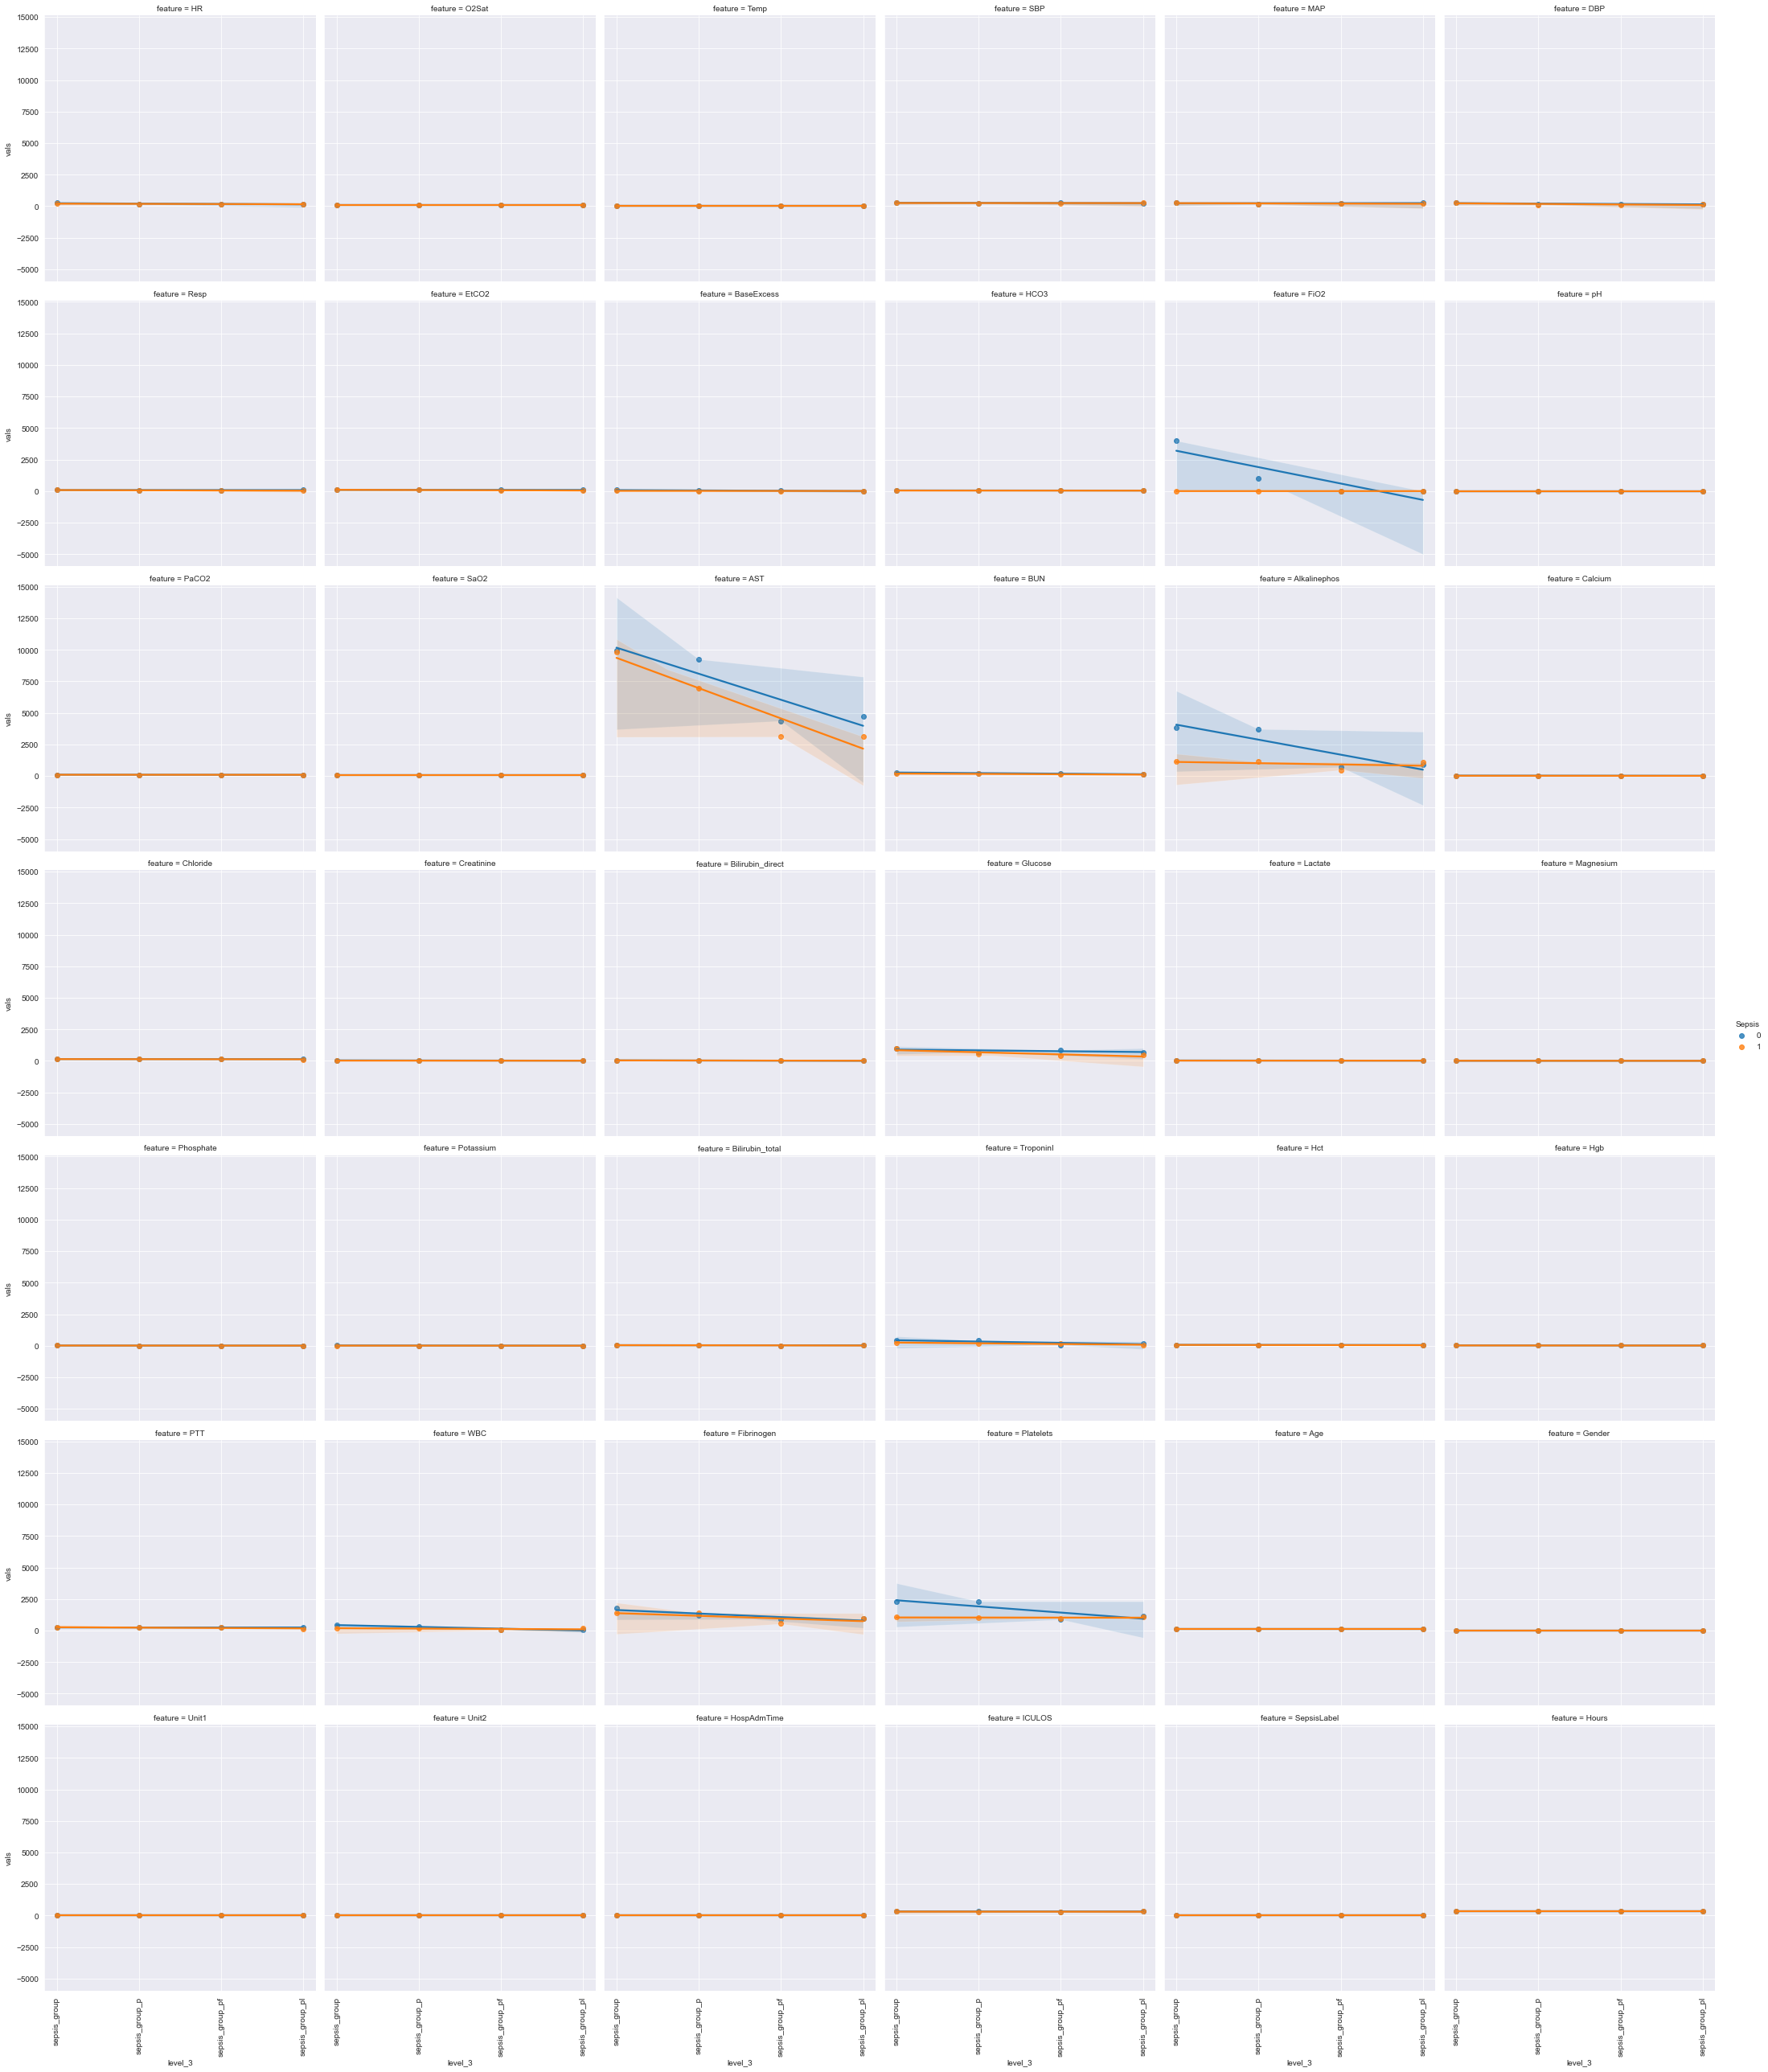

In [319]:
# plots.py

# https://seaborn.pydata.org/generated/seaborn.lmplot.html

# Show the results of a linear regression within each dataset
g = sns.lmplot(
    # data = df_seps_groups,
    # data = df_seps_groups.T.stack().T.unstack().to_frame().reset_index(level = [0, 2, 3]).reset_index(drop = True).rename(columns = {0: "vals"}),
    data = df_seps_groups.rename(index = {"sepsis_group": 0, "sepsis_group_p": 1, "sepsis_group_pf": 2, "sepsis_group_pl":3}).T.stack().T.unstack().to_frame().reset_index(level = [0, 2, 3]).reset_index(drop = True).rename(columns = {0: "vals", "level_0": "feature"}),
    # x = df.groupby(level = 0).HR.count(),
    x = "level_3",
    y = "vals",
    col = "feature",
    hue = "Sepsis",
    col_wrap = 6,
    # ci = None,
    # palette = "muted",
    # height = 4,
    # scatter_kws = {"s": 50, "alpha": 1},
)
xlabels = df_seps_groups[("HR", "max")].index.get_level_values(0).unique()
g.set(xticks = range(len(xlabels))).set_xticklabels(xlabels, rotation = "vertical")
# plt.gca().set_xticklabels(xlabels, rotation = "vertical")
# plt.xticks(range(len(xlabels)), xlabels, rotation = "vertical")

# plt.title(f'{viz_feature} against Sepsis patient wise')
plt.show()

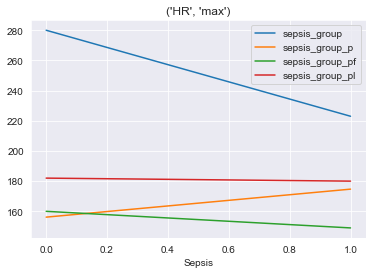

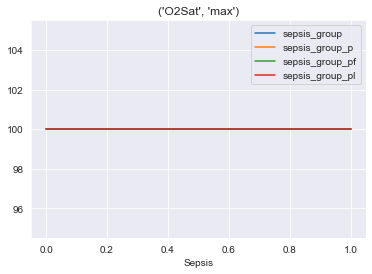

In [286]:
# plots.py

# df_seps_groups[("HR", "max")].index.get_level_values(0).unique()
df_seps_groups[("HR", "max")].loc[(slice(None), 0)]


for c in df_seps_groups.columns[:2]:
    plt.plot(
        # df_seps_groups[c].values
        [df_seps_groups[c].loc[(slice(None), 0)],
        df_seps_groups[c].loc[(slice(None), 1)]],
        label = df_seps_groups[("HR", "max")].index.get_level_values(0).unique(),
        )
    # plt.gca().set_xticklabels(df_seps_groups[("HR", "max")].index.get_level_values(0).unique())
    plt.legend()
    plt.title(c)
    plt.xlabel("Sepsis")
    plt.show()
    # break

In [ ]:
# get #-measurements per patients and take xth-quantile
sepsis_length_quantil = dfa.reset_index().groupby("PatientID").level_1.count().quantile(.66)
print(sepsis_length_quantil)

# hist of "patient stay lenght" that had sepsis
# dfa[dfa.SepsisLabel == 1].reset_index().level_1.hist(bins = 100)
dfa.ICULOS[dfa.SepsisLabel == 1].groupby("PatientID").tail(1).plot.hist(bins = 100)
dfa.Hours[dfa.SepsisLabel == 1].groupby("PatientID").tail(1).plot.hist(bins = 100, alpha = .6)
plt.gca().set_xlabel("Hospital stay length")
plt.axvline(sepsis_length_quantil, c = "m", label = "Quantil")
plt.legend()
plt.show()

# hist of timepoint when sepsis occured
dfa[dfa.SepsisLabel == 1].ICULOS.plot.hist(bins = 100)
plt.gca().set_xlabel("Time when sepsis occured")
plt.axvline(sepsis_length_quantil, c = "m", label = "Quantil")
plt.show()

# clip measurements at xth-quantil
df.groupby("PatientID").head(sepsis_length_quantil)

In [ ]:
# clip measurements at xth-quantil

dfa = dfa.rename_axis(index = ["PatientID", "MeasureCount"], columns = "Features")
df_timeseries = dfa.groupby("PatientID").head(sepsis_length_quantil)
df_timeseries = df_timeseries.stack().swaplevel("MeasureCount", "Features").unstack().T

#  select one feature over all patients
feature_names = df_timeseries.columns.unique(1)
df_timeseries.loc[:, (slice(None), feature_names[0])]

# TODO: Age: const per patient

,level_0,Sepsis,level_3,0
0,HR,0,sepsis_group,280.000000
1,HR,0,sepsis_group_p,156.142857
2,HR,0,sepsis_group_pf,160.000000
3,HR,0,sepsis_group_pl,182.000000
4,HR,1,sepsis_group,223.000000
...,...,...,...,...
331,Hours,0,sepsis_group_pl,336.000000
332,Hours,1,sepsis_group,336.000000
333,Hours,1,sepsis_group_p,336.000000
334,Hours,1,sepsis_group_pf,336.000000


<AxesSubplot:xlabel='0', ylabel='level_0'>

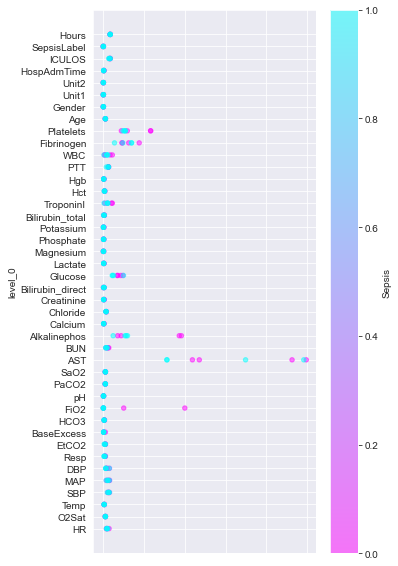

In [282]:
# plots.py

# df_seps_groups.reset_index().T.reset_index(level = 0).reset_index(drop = True)
display(df_seps_groups.T.stack().T.unstack().to_frame().reset_index(level = [0, 2, 3]).reset_index(drop = True))
df_seps_groups.T.stack().T.unstack().to_frame().reset_index(level = [0, 2, 3]).reset_index(drop = True).plot(
    kind = "scatter",
    # kind = "box",
    # x = "Sepsis", y = 0,
    x = 0, y = "level_0", c = "Sepsis", cmap = plt.cm.cool_r,
    # x = "Sepsis", y = "level_0", c = 0, cmap = plt.cm.cool,
    # x = "level_3", y = "level_0", c = "Sepsis", cmap = plt.cm.cool,
    # cmap = plt.cm.tab20,
    alpha = .5,
    figsize = (5, 10),
)

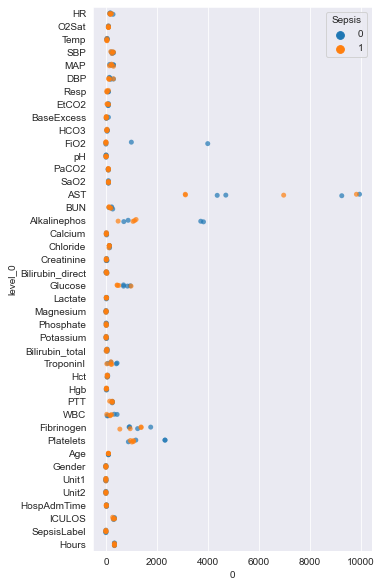

In [180]:
# plots.py

ax = sns.stripplot(
    data = df_seps_groups.T.stack().T.unstack().to_frame().reset_index(level = [0, 2, 3]).reset_index(drop = True),
    x = 0,
    y = "level_0",
    hue = "Sepsis",
    cmap = plt.cm.cool,
    jitter = .1,
    alpha = .7,
)
plt.gcf().set_size_inches(5, 10)
plt.show()

Index(['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2',
       'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
       'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
       'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
       'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
       'Fibrinogen', 'Platelets', 'Age', 'Gender', 'Unit1', 'Unit2',
       'HospAdmTime', 'ICULOS', 'SepsisLabel', 'Sepsis', 'Hours'],
      dtype='object')


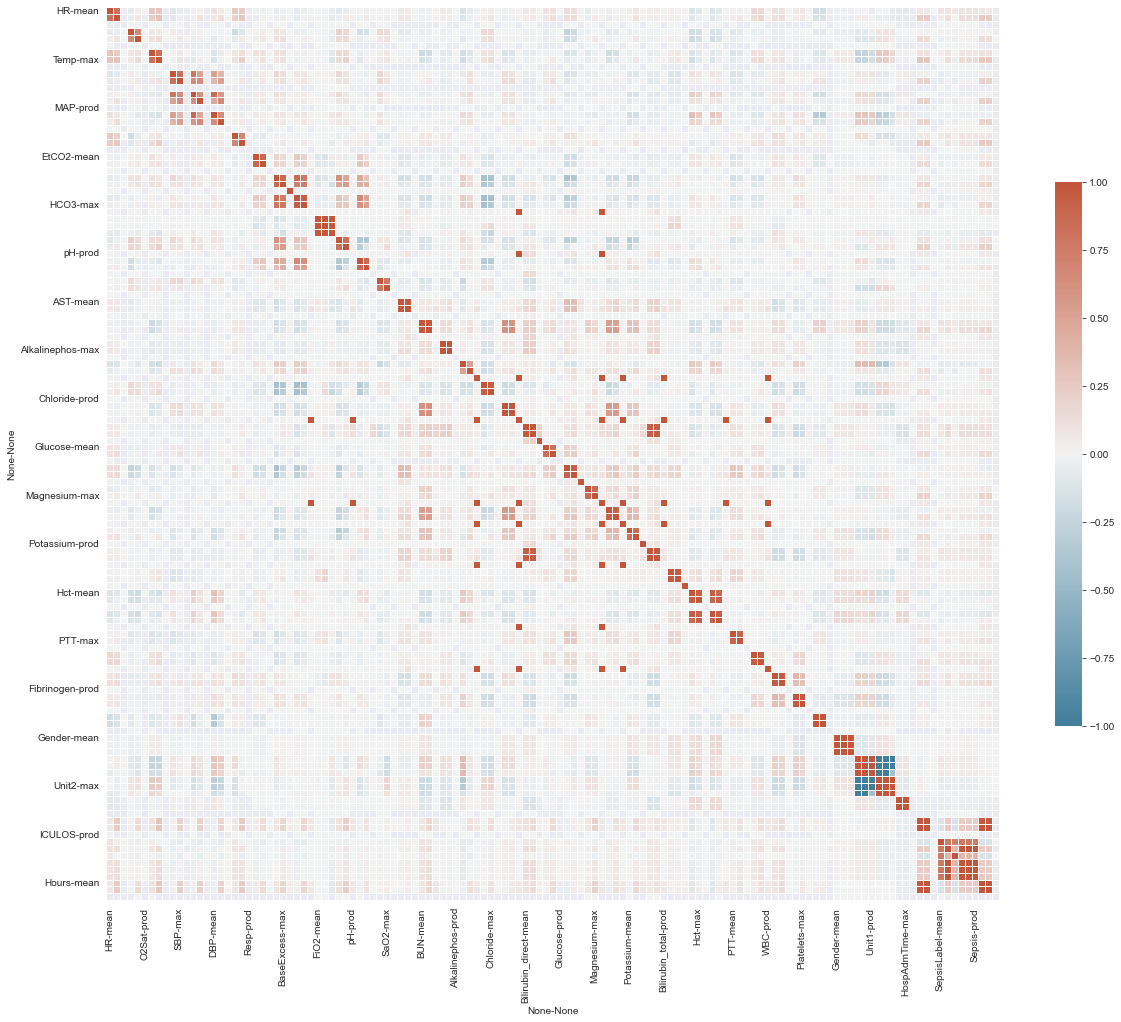

In [586]:
# plots.py

dfg = df.groupby(level = 0).agg(["mean", "max", "prod"])  # mean median min max count sum prod var std
# dfg = df.groupby(level = 0).max()
# dfg = df.groupby(level = 0).agg(["median"])
# dfg = df.groupby(level = 0).mean()

corr = dfg.corr()
# corr = df.corr()

sns.heatmap(
    corr,
    # mask = np.triu(np.ones_like(corr, dtype = bool)),
    cmap = sns.diverging_palette(230, 20, as_cmap = True),
    # vmax = .3,
    center = 0,
    square = True,
    linewidths = .5,
    cbar_kws = {"shrink": .5})

plt.gcf().set_size_inches(20, 20)

print(df.columns)

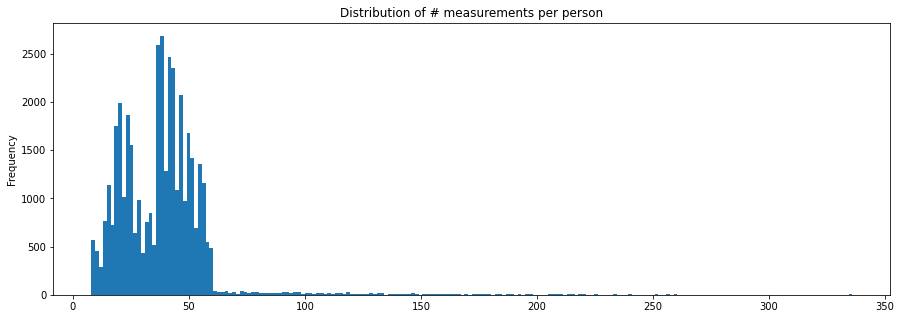

In [173]:
# plots.py

df.reset_index(level = 1).level_1.groupby(level = 0).count().plot(
    kind = "hist",
    figsize = (15, 5), bins = 200, logy = True*0,
    # cumulative = True,
    # by = "Gender",
    # alpha = .4,
    title = "Distribution of # measurements per person");

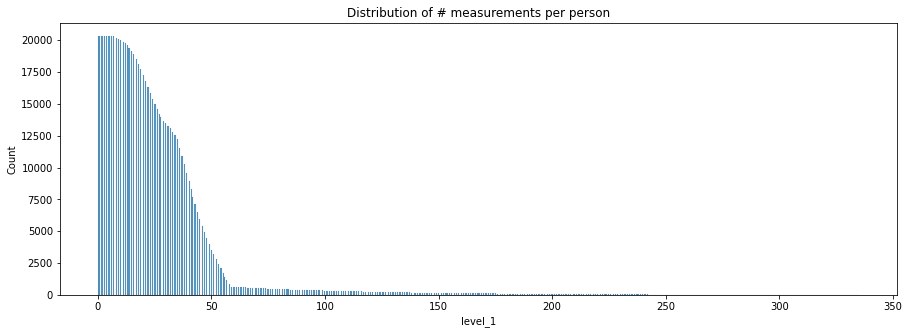

In [345]:
# plots.py

sns.histplot(df.reset_index(level = 1).level_1, stat = "count")
plt.title("Distribution of # measurements per person")
plt.gcf().set_size_inches(15, 5);

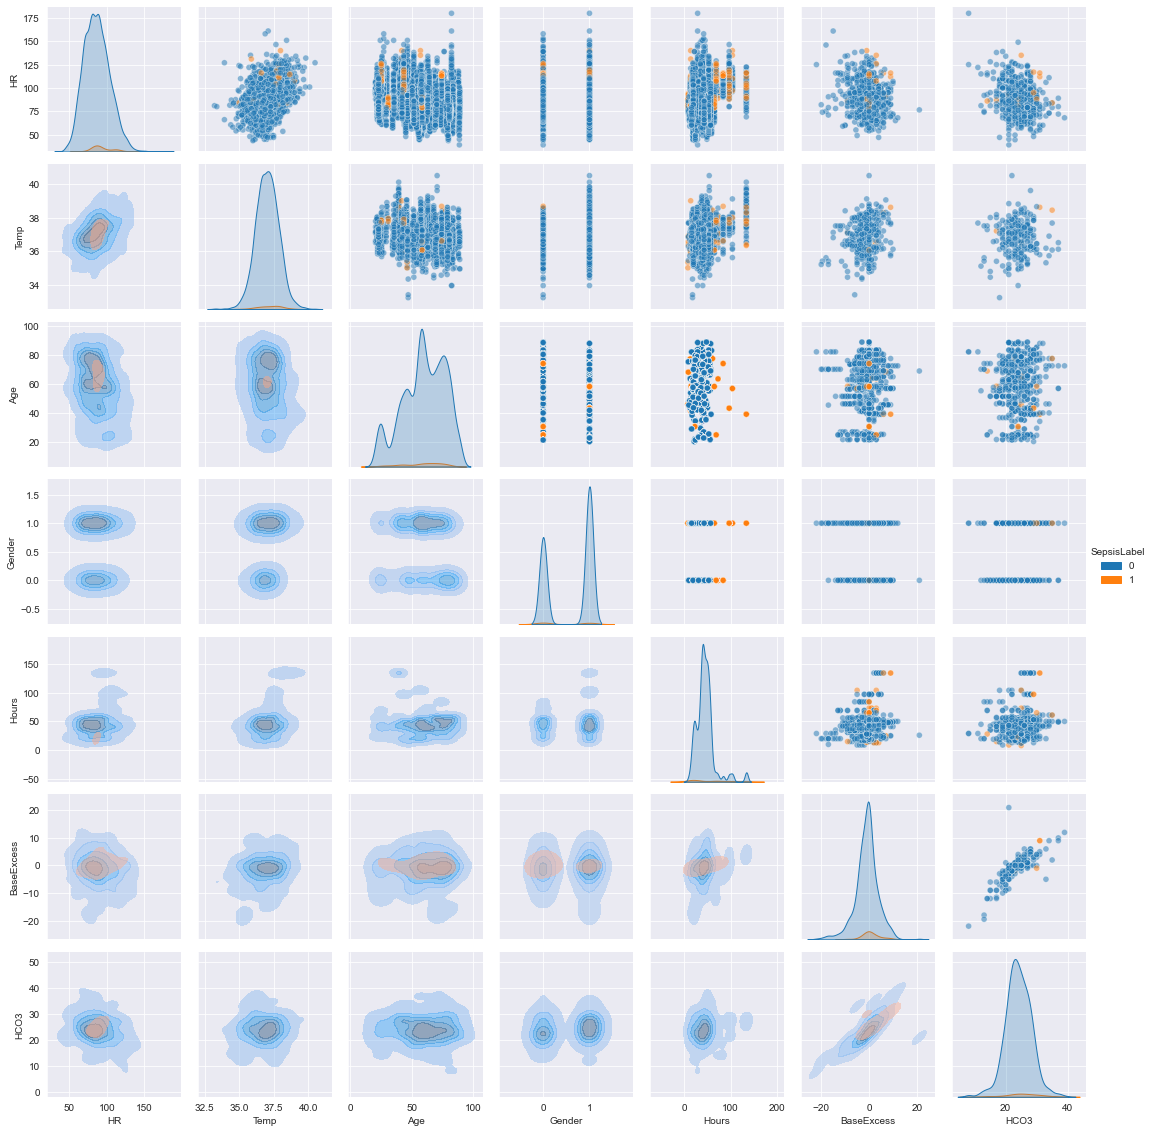

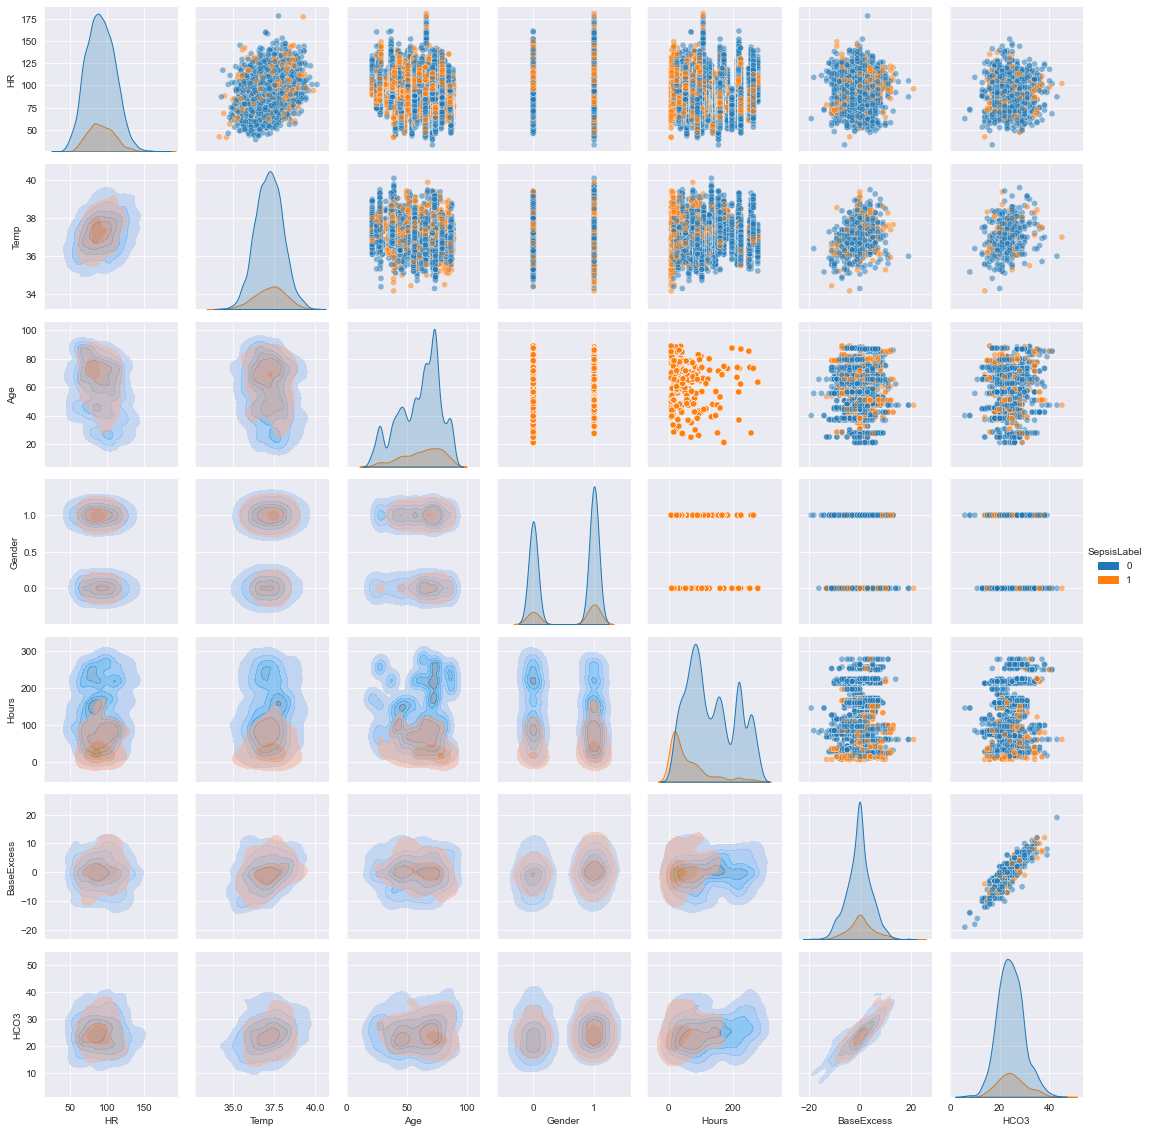

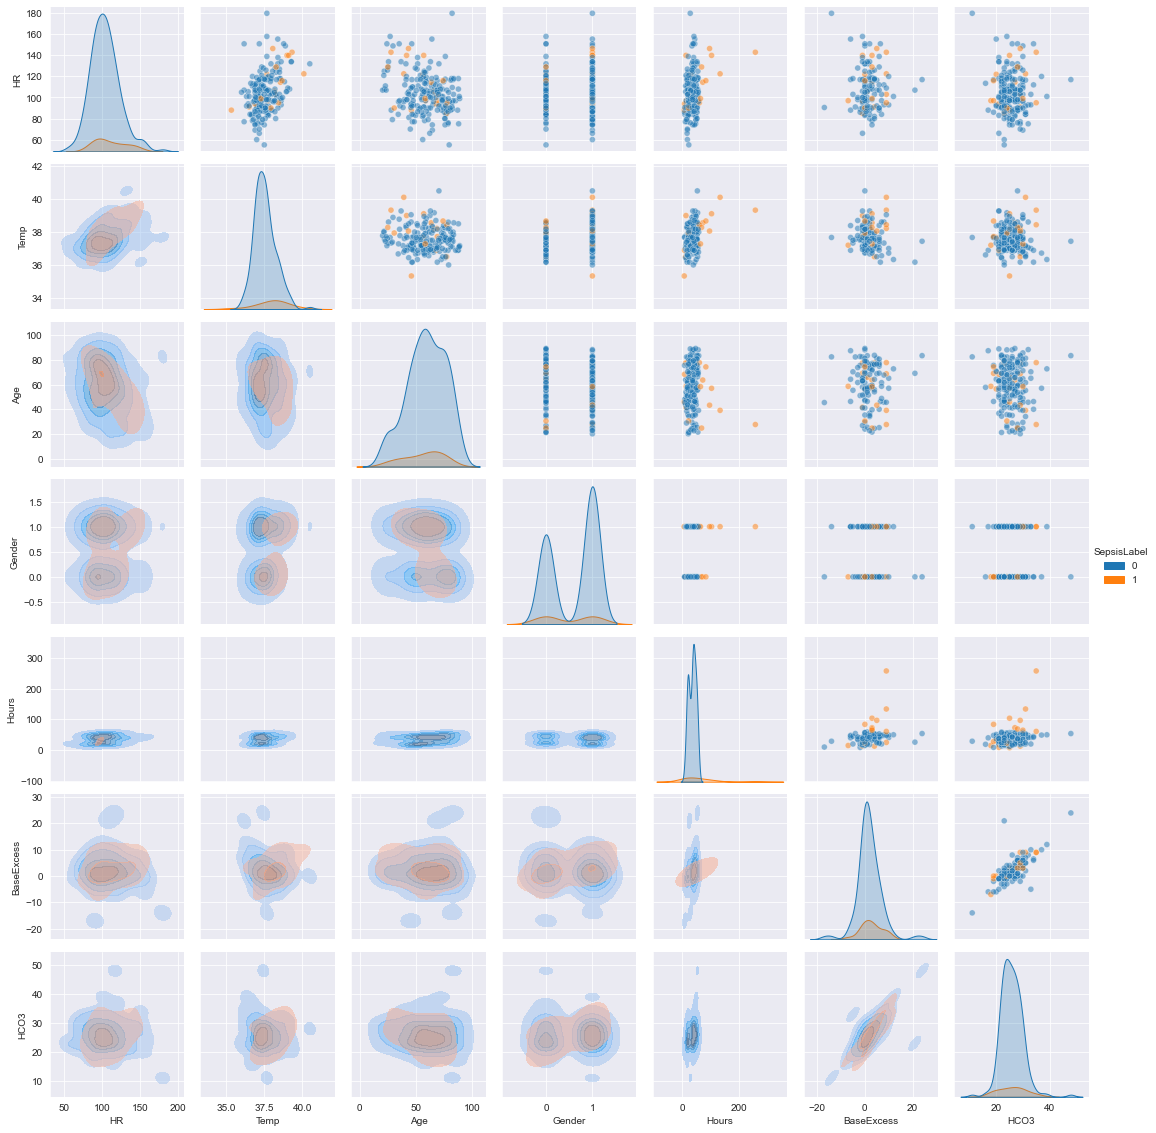

In [563]:
# plots.py

# https://seaborn.pydata.org/generated/seaborn.pairplot.html

for dfx in [
    df.loc[slice(10, 200)],
    df.loc[df.loc[df.SepsisLabel.values == 1].index.get_level_values(0).unique()[:200]],  # patients with sepsis
    # df.groupby(level = 0).mean().loc[slice(0, 200)],
    # df.groupby(level = 0).min().loc[slice(0, 200)],
    df.groupby(level = 0).max().loc[slice(0, 200)],
    # df.groupby(level = 0).agg(["median"]).loc[slice(0, 200)],
    ]:
    g = sns.PairGrid(
        dfx,
        hue = "SepsisLabel",
        # kind = "kde",  # hist kde
        # diag_kind = "hist",
        # markers = ["o", "s", "D"],
        # height = 1.5,
        dropna = True,
        x_vars = [
            # 'HR', 'O2Sat', 'Temp', 'Resp', 'Age', 'Gender', "Hours",
            'HR', 'Temp', 'Age', 'Gender', "Hours", 'BaseExcess', 'HCO3',
            # "SepsisLabel",
            # 'HR', 'O2Sat', 'Temp',
            # 'SBP', 'MAP', 'DBP',
            # 'Resp',
            # 'EtCO2',
            # 'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
            # 'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
            # 'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
            # 'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
            # 'Fibrinogen', 'Platelets',
            ],
        y_vars = [
            'HR', 'Temp', 'Age', 'Gender', "Hours", 'BaseExcess', 'HCO3',
            # 'Age', 'Gender', 'Unit1', 'Unit2', 'HospAdmTime', 'ICULOS', 'SepsisLabel'
            ],
        # corner = True,
        # plot_kws = dict(marker = "+", linewidth = 1),
        # diag_kws = dict(fill = False),
        # levels = 4,
        # color = ".2",
        diag_sharey = False,
        )
    g.map_upper(sns.scatterplot, alpha = .5)
    g.map_diag(sns.kdeplot, fill = True)
    g.map_lower(sns.kdeplot, levels = 6, fill = True, alpha = .5, lw = 1)
    g.add_legend()
    plt.gcf().set_size_inches(16, 16);
    plt.show()

In [ ]:
# plots.py

# Plot each year's time series in its own facet
g = sns.relplot(
    data = df,
    x = "month",
    y = "passengers",
    col = "year",
    hue = "year",
    kind = "line",
    palette = "crest",
    linewidth = 4,
    zorder = 5,
    col_wrap = 3,
    height = 2,
    aspect = 1.5,
    legend = False,
)

# Iterate over each subplot to customize further
for year, ax in g.axes_dict.items():

    # Add the title as an annotation within the plot
    ax.text(.8, .85, year, transform = ax.transAxes, fontweight = "bold")

    # Plot every year's time series in the background
    sns.lineplot(
        data = flights,
        x = "month",
        y = "passengers",
        units = "year",
        estimator = None,
        color = ".7",
        linewidth = 1,
        ax = ax,
    )

# Reduce the frequency of the x axis ticks
ax.set_xticks(ax.get_xticks()[::2])

# Tweak the supporting aspects of the plot
g.set_titles("")
g.set_axis_labels("", "Passengers")
g.tight_layout()

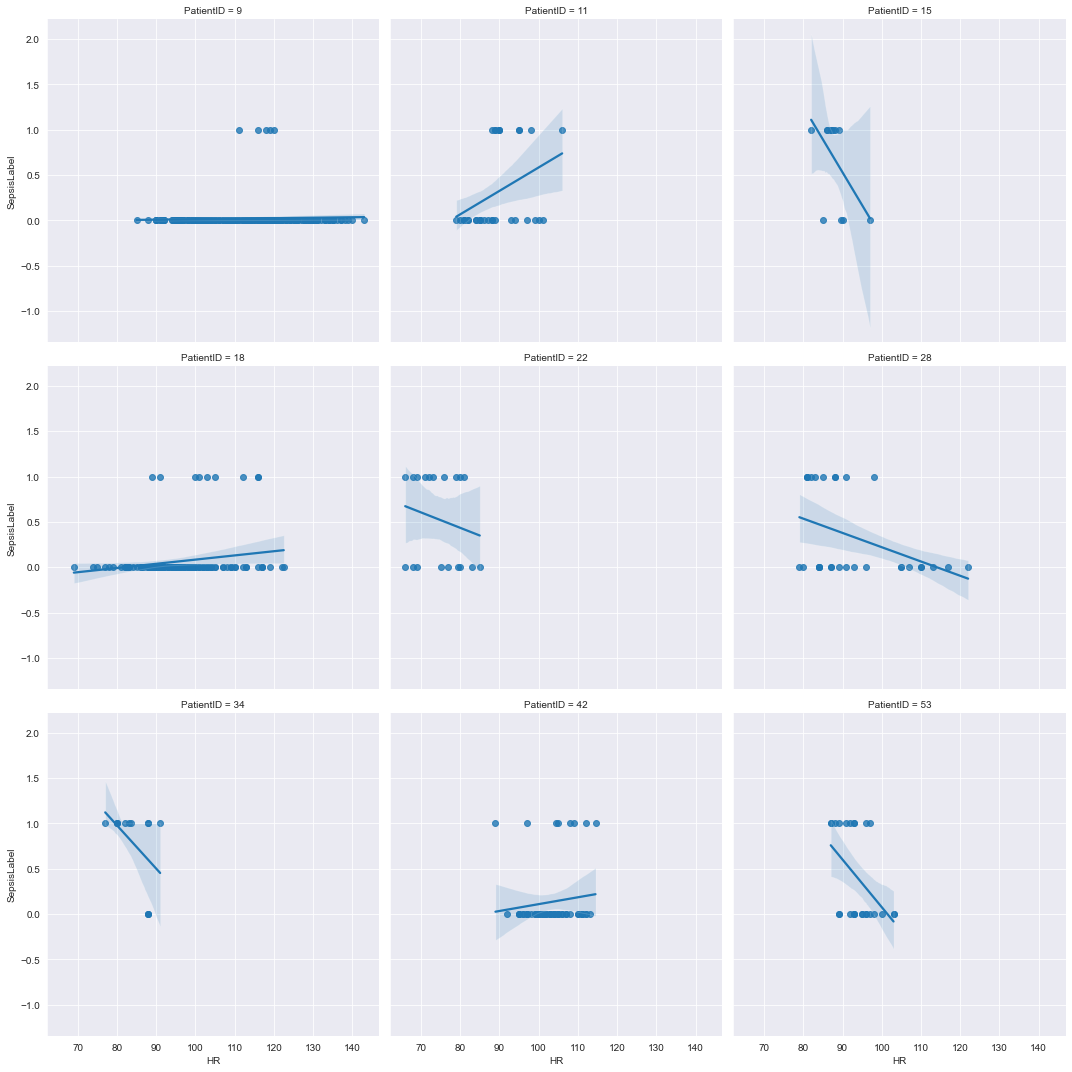

In [353]:
# plots.py

# https://seaborn.pydata.org/generated/seaborn.lmplot.html

viz_feature = "HR"

# Show the results of a linear regression within each dataset
sns.lmplot(
    # data = df.loc[(slice(0, 6),), :].reset_index().drop("level_1", 1),
    data = df.loc[df.loc[df.SepsisLabel.values == 1].index.get_level_values(0).unique()[:9]].reset_index().drop("level_1", 1),
    # x = df.groupby(level = 0).HR.count(),
    x = viz_feature,
    y = "SepsisLabel",
    col = "PatientID",
    # hue = "Age",
    col_wrap = 3,
    # ci = None,
    # palette = "muted",
    # height = 4,
    # scatter_kws = {"s": 50, "alpha": 1},
)
plt.title(f'{viz_feature} against Sepsis patient wise')

### snippets

In [71]:
# stats.py

# ICULOS doesn't always start at 1
df.loc[(slice(None), 0), :].ICULOS

PatientID   
000001     0    1
000002     0    1
000003     0    1
000004     0    1
000005     0    2
               ..
119996     0    1
119997     0    1
119998     0    1
119999     0    1
120000     0    1
Name: ICULOS, Length: 40336, dtype: int64

In [74]:
# stats.py

# stats per person

df.groupby(level = 0).mean()
df.groupby(level = 0).std()
df.groupby(level = 0).agg(["mean", "std", "min", "max"])
# df.loc[1].agg(["mean", "std", "min", "max"])

HR                              O2Sat                  \
                 mean        std   min    max       mean       std   min   
PatientID                                                                  
000001     101.571429   9.594378  76.0  117.0  91.477273  3.460667  85.0   
000002      60.954545   8.144395  54.0   94.0  97.000000  2.138090  94.0   
000003      79.611111   6.714036  68.0   93.0  95.431818  1.655122  91.0   
000004     102.444444   6.337212  93.0  113.0  98.203704  1.449531  95.5   
000005      73.916667   7.586697  61.0   88.0  97.500000  0.741620  96.0   
...               ...        ...   ...    ...        ...       ...   ...   
119996      89.456522  12.802702  69.0  124.0  98.086957  1.007220  95.0   
119997      61.062500  10.742351  44.0   80.0  96.833333  2.292078  89.0   
119998      80.202381   9.620899  57.0  103.0  96.255814  3.875092  88.0   
119999      94.333333   5.291503  87.0  106.0  92.722222  3.922867  83.0   
120000      82.727273   7.160101  72.0  101.0  98.045455  0.860266  96.0   

                       Temp                                 SBP             \
             max       mean       std    min    max        mean        std   
PatientID                                                                    
000001     100.0  36.778000  0.421078  36.11  37.44  126.809524  22.422482   
000002     100.0  36.165000  0.151625  36.00  36.44  136.600000  20.180613   
000003      99.0  37.609375  0.565597  36.89  38.61  140.033333   8.954684   
000004     100.0  36.455000  0.262507  36.06  36.78  113.019231   9.013857   
000005      99.0  36.992222  0.423520  36.22  37.33  132.770833   9.908252   
...          ...        ...       ...    ...    ...         ...        ...   
119996     100.0  36.400000  0.343188  35.70  37.00  131.366667  17.514410   
119997     100.0  36.800000  0.500000  36.30  37.30  119.562500  16.434529   
119998     100.0  36.733333  0.467748  36.00  37.60  157.526316  23.147864   
119999     100.0  37.620000  0.294958  37.20  37.90  141.722222   9.373339   
120000      99.0  36.714286  0.203540  36.40  37.00  127.106061  14.242190   

                                MAP                                  DBP  \
             min    max        mean        std    min     max       mean   
PatientID                                                                  
000001      78.0  181.0   87.261905  21.270465  44.00  141.33        NaN   
000002     114.0  194.0   66.704545  14.720134  50.50  116.00  44.066667   
000003     122.0  159.0   81.048000   7.854301  62.67   99.00  54.392857   
000004      90.0  132.5   67.147308  10.048494  34.00   84.00  51.428571   
000005     114.0  150.0   87.088235   8.631764  73.00  103.00        NaN   
...          ...    ...         ...        ...    ...     ...        ...   
119996      81.0  164.0   84.602273  10.819115  60.00  105.00  71.922222   
119997      97.0  156.0   90.937500  25.734984  63.00  193.50  70.250000   
119998     119.0  205.5  116.157895  17.753608  79.00  158.50  88.644737   
119999     128.0  164.0  100.833333   7.350470  90.00  114.00  74.416667   
120000     110.0  168.0   92.030303   9.678374  78.00  119.00  71.015152   

                                        Resp                       EtCO2      \
                 std   min    max       mean       std   min   max  mean std   
PatientID                                                                      
000001           NaN   NaN    NaN  24.820000  4.106689  17.0  32.0   NaN NaN   
000002      7.095941  36.0   66.0  14.236842  4.667763   9.0  27.0   NaN NaN   
000003      5.258600  44.0   69.0  25.633333  4.247192  17.0  40.0   NaN NaN   
000004      6.129554  44.0   61.5  18.884615  3.742480  14.0  26.0   NaN NaN   
000005           NaN   NaN    NaN  16.500000  1.788854  14.0  21.0   NaN NaN   
...              ...   ...    ...        ...       ...   ...   ...   ...  ..   
119996     11.654084  43.0  109.0  19.176471  1.766191  16.0  23.0   NaN NaN

In [8]:
# stats.py

# find low quality features
df.groupby(level = 0).count().sum().to_frame() #.plot(figsize = (15, 5))
# => EtCO2 was NEVER measured in dataset A

,0
PatientID,790215
HR,729026
O2Sat,695136
Temp,266901
SBP,670014
MAP,709357
DBP,409918
Resp,712957
EtCO2,0
BaseExcess,82381


In [6]:
# min 1 count per patient

(df.groupby(level = "PatientID").count() > 0).sum().to_frame()

,0
HR,20335
O2Sat,20324
Temp,20101
SBP,20078
MAP,20334
DBP,12952
Resp,20308
EtCO2,0
BaseExcess,12652
HCO3,19801


In [ ]:
# stats.py

# Unit1 & Unit2 are sparsely labeled

# print(dfa.Unit1.value_counts(dropna = False))
# print(dfa.loc[:, ["Unit1", "Unit2"]].fillna(-1).value_counts())
# print(dfb.loc[:, ["Unit1", "Unit2"]].fillna(-1).value_counts())

# print(dfa.loc[:, ["Unit1", "Unit2"]].groupby(level = "PatientID").mean().fillna(-1).value_counts())
# print(dfa.Unit1.groupby(level = "PatientID").mean().value_counts(dropna = False))

display(pd.concat([
        pd.concat([x[1].value_counts(dropna = False, normalize = 1*True) for x in dfa.loc[:, ["Unit1", "Unit2"]].groupby(level = "PatientID").mean().items()], axis = 1),
        pd.concat([x[1].value_counts(dropna = False, normalize = 1*True) for x in dfb.loc[:, ["Unit1", "Unit2"]].groupby(level = "PatientID").mean().items()], axis = 1),
        pd.concat([x[1].value_counts(dropna = False, normalize = 1*True) for x in df.loc[:, ["Unit1", "Unit2"]].groupby(level = "PatientID").mean().items()], axis = 1),
    ], axis = 1, keys = ["A", "B", "all"]).round(2))

In [37]:
# stats.py

# patient who developed sepsis

# patients_with_sepsis = df.loc[df.SepsisLabel.values == 1].index.get_level_values(0)
patients_with_sepsis = (df.groupby(level = 0).SepsisLabel.sum().to_frame() > 0).sum() #.plot(figsize = (15, 5))
print(f'{patients_with_sepsis = }')
df.SepsisLabel.sum()

patients_with_sepsis = SepsisLabel    2932
dtype: int64


27916

In [507]:
# stats.py

# Patients with Sepsis

df.loc[df.loc[df.SepsisLabel.values == 1].index.get_level_values(0).unique()]

# first 10 patients with sepsis
# df.loc[df.loc[df.SepsisLabel.values == 1].index.get_level_values(0).unique()[:10]]

HR  O2Sat  Temp    SBP    MAP   DBP  Resp  EtCO2  BaseExcess  \
PatientID                                                                       
9         0     NaN    NaN   NaN    NaN    NaN   NaN   NaN    NaN         NaN   
          1   117.0   99.0   NaN  116.0   97.0  81.0  20.0    NaN         NaN   
          2     NaN    NaN   NaN    NaN    NaN   NaN   NaN    NaN        -7.0   
          3     NaN    NaN   NaN    NaN    NaN   NaN   NaN    NaN        -4.0   
          4     NaN    NaN   NaN    NaN    NaN   NaN   NaN    NaN        -1.0   
...             ...    ...   ...    ...    ...   ...   ...    ...         ...   
119959    36   91.0   96.0  37.0  127.0   94.0  75.0   NaN    NaN         NaN   
          37   91.0   95.0  36.7  151.0  103.0  74.0  24.0    NaN         NaN   
          38   95.0   94.0  36.6  150.0  104.0  74.0  23.0    NaN         NaN   
          39   91.0   95.0  36.7  131.0   92.0  72.0  21.0    NaN         NaN   
          40   99.0   94.0  36.9  132.0   89.0  64.0  20.0    NaN         NaN   

              HCO3  FiO2    pH  PaCO2  SaO2  AST  BUN  Alkalinephos  Calcium  \
PatientID                                                                      
9         0    NaN   NaN   NaN    NaN   NaN  NaN  NaN           NaN      NaN   
          1    NaN   NaN   NaN    NaN   NaN  NaN  NaN           NaN      NaN   
          2   23.0   NaN  7.15   66.0  99.0  NaN  NaN           NaN      NaN   
          3    NaN   NaN  7.13   80.5  96.0  NaN  NaN           NaN      NaN   
          4    NaN   NaN  7.30   52.0  98.0  NaN  NaN           NaN      NaN   
...            ...   ...   ...    ...   ...  ...  ...           ...      ...   
119959    36   NaN   NaN   NaN    NaN   NaN  NaN  NaN           NaN      NaN   
          37   NaN   NaN   NaN    NaN   NaN  NaN  NaN           NaN      NaN   
          38   NaN   NaN   NaN    NaN   NaN  NaN  NaN           NaN      NaN   
          39   NaN   NaN   NaN    NaN   NaN  NaN  NaN           NaN      NaN   
          40   NaN   NaN   NaN    NaN   NaN  NaN  NaN           NaN      NaN   

              Chloride  Creatinine  Bilirubin_direct  Glucose  Lactate  \
PatientID                                                                
9         0        NaN         NaN               NaN      NaN      NaN   
          1        NaN         NaN               NaN      NaN      NaN   
          2        NaN         NaN               NaN    123.0      3.6   
          3        NaN         NaN               NaN    117.5      2.7   
          4        NaN         NaN               NaN    102.0      3.8   
...                ...         ...               ...      ...      ...   
119959    36       NaN         NaN               NaN    208.0      NaN   
          37       NaN         NaN               NaN      NaN      NaN   
          38       NaN         NaN               NaN      NaN      NaN   
          39       NaN         NaN               NaN      NaN      NaN   
          40       NaN         NaN               NaN      NaN      NaN   

              Magnesium  Phosphate  Potassium  Bilirubin_total  TroponinI  \
PatientID                                                                   
9         0         NaN        NaN        NaN              NaN        NaN   
          1         NaN        NaN        NaN              NaN        NaN   
          2         NaN        NaN        4.0              NaN        NaN   
          3         NaN        NaN        3.6              NaN        NaN   
          4         NaN        NaN        3.6              NaN        NaN   
...                 ...        ...        ...              ...        ...   
119959    36        NaN        NaN        NaN              NaN        NaN   
          37        NaN        NaN        NaN              NaN        NaN   
          38        NaN        NaN        NaN              NaN        NaN   
          39        NaN        NaN        NaN              NaN        NaN   
          40        NaN        NaN 

,PatientID,feature,pct
0,1,HR,0.907407
1,1,O2Sat,0.814815
2,1,Temp,0.185185
3,1,SBP,0.777778
4,1,MAP,0.777778
...,...,...,...
874443,20643,HospAdmTime,1.000000
874444,20643,ICULOS,1.000000
874445,20643,SepsisLabel,1.000000
874446,20643,Sepsis,1.000000


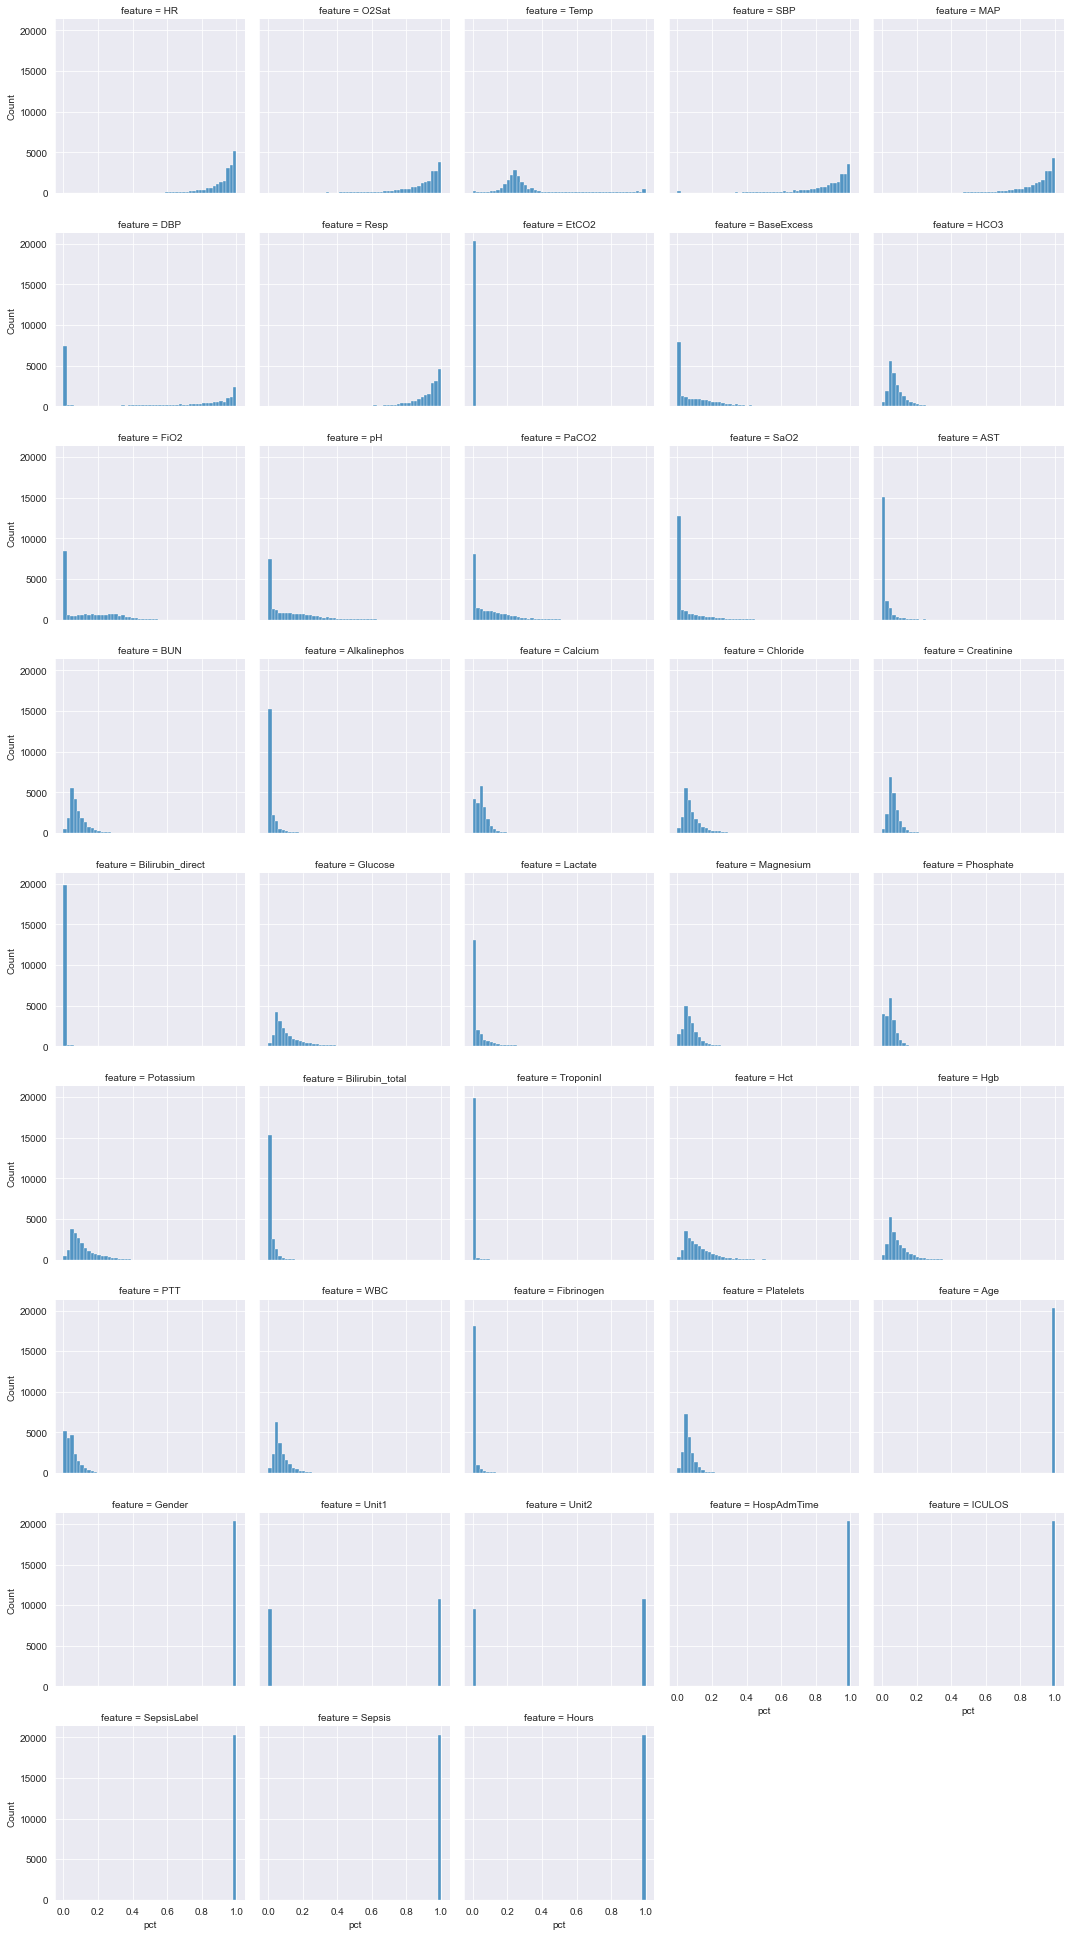

In [41]:
# number of measured feature per patient [percentage]

# df = load_challenge_data(PATHs.train_a_merge_file, sep = "|", use_dask = False, preprocess = True)

df_no_features_pct = (df.groupby(level = 0).count().T /
                      df.groupby(level = 0).Hours.count()).T.stack().reset_index().rename(columns = {
                          0: "pct", "level_1": "feature"
                      })
display(df_no_features_pct)

sns.displot(
    df_no_features_pct,
    kind = "hist",
    x = "pct",
    col = "feature",
    # row = "sex",
    col_wrap = 5,
    # binwidth = 3,
    height = 3,
    # facet_kws = dict(margin_titles = True),
)

In [169]:
df.reset_index(level = 1).level_1.groupby(level = 0).count()

PatientID
1         54
2         23
3         48
4         29
5         48
          ..
119996    48
119997    25
119998    49
119999    20
120000    35
Name: level_1, Length: 40336, dtype: int64

### Testing

In [324]:
# testing.py

"""
Sanity checks
"""

print("# check if labels which should always have a value actually have one")
labels_which_should_have_a_val = ['Age', 'Gender', 'Unit1', 'Unit2', 'HospAdmTime', 'ICULOS', 'SepsisLabel']
print(df.loc[:, labels_which_should_have_a_val].isna().agg(["any", "sum"]).T)

print("\n# check age doesn't change")
print(df.Age.groupby(level=0).std().max())

# TODO: zeitreihen analyse => vergleichen mit: ohne dataframe sondern durch Dateien loopen

# check if labels which should always have a value actually have one
               any     sum
Age          False       0
Gender       False       0
Unit1         True  386165
Unit2         True  386165
HospAdmTime   True       8
ICULOS       False       0
SepsisLabel  False       0

# check age
0.0


### 3rd Party stats libs

In [ ]:
%pip install pysubgroup

#### pandas_profiling

- You can see when comparing the different reports that converting values from int to bool saves 6.8MB (11.8MB -> 3MB)

In [54]:
# !rm -rf {PATHs.DATA_PATH.as_posix()}
# PATHs.DATA_PATH.mkdir(exist_ok = True)

# def pandas_profiling_physionet2019():

dfa = load_data_set("A")
dfb = load_data_set("B")
df = load_challenge_data(PATHs.train_all_merge_file, sep = ";", use_dask = False, preprocess = True)


def flatten_multiindex_cols(df):
    """
    pandas profiling cannot handle multiindex columns
    https://github.com/pandas-profiling/pandas-profiling/issues/838
    """
    df.columns = ["-".join(c) for c in df.columns]
    return df


for filename, prargs in [
                    (f'MultiIndex-minimal', {"df": df, "minimal": True}),
                ] + [x for y in [[  # for A & B & all
                    (f'agg-mean-{set_name}',    {"df": dfx.groupby(level = 0).mean()}),
                    (f'agg-median-{set_name}',  {"df": dfx.groupby(level = 0).median()}),
                    (f'agg-count-{set_name}',   {"df": dfx.groupby(level = 0).count()}),
                    (f'agg-max-{set_name}',     {"df": dfx.groupby(level = 0).max()}),
                    (f'agg-min-{set_name}',     {"df": dfx.groupby(level = 0).min()}),
                ] for dfx, set_name in [(dfa, "A"), (dfb, "B"), (df, "all")]] for x in y
                ] + [x for y in [[  # for A & B
                    (f'MultiIndex-{set_name}',  {"df": dfx, "minimal": False}),
                    (f'agg-min-max-{set_name}', {"df": dfx.groupby(level = 0).agg(["min", "max"])}),
                    (f'agg-mean-med-{set_name}',{"df": dfx.groupby(level = 0).agg(["mean", "median"])}),
                    (f'agg-min-max-mean-med-{set_name}',{"df": dfx.groupby(level = 0).agg(["min", "max", "mean", "median"])}),
                ] for dfx, set_name in [(dfa, "A"), (dfb, "B")]] for x in y]:
    t0 = time.time()
    profile = ProfileReport(
        # df = df,
        # df = df[df.PatientID < 100],
        # title = "Physionet Data Challenge 2019 - Pandas Profiling Report",
        title = f'Physionet Data Challenge 2019 - ({filename})',
        # explorative = True,
        # minimal = True,  # for large datasets
        # sort = None,  # None "ascending" "descending"
        html = {
            "style": {"full_width": True},
            "inline": True,
        },
        # vars = {
        #     "num": {
        #         "low_categorical_threshold": 0,
        #         "quantiles": [0.05,0.25,0.5,0.75,0.95],
        #     },
        #     "cat": {
        #         "length": True,
        #         "characters": False,
        #         "words": False,
        #         "n_obs": 5,
        #     },
        #     "bool": {
        #         "n_obs": 5,
        #     }
        # },
        # missing_diagrams = {
        #     # "bar": False,
        #     "matrix": False,
        #     "heatmap": False,
        #     "dendrogram": False,
        # },
        correlations = {
            # "spearman": {"warn_high_correlations": True},
            # "kendall": {"warn_high_correlations": True},
            "phi_k": {"calculate": False, "warn_high_correlations": True},  # because it crashes...
        },
        interactions = {
            "continuous": True,  # Generate a 2D scatter plot (or hexagonal binned plot) for all continuous variable pairs.
            "targets": ["SepsisLabel", "Sepsis", "Hours"],  # When a list of variable names is given, only interactions between these and all other variables are given.
        },
        **prargs
    )
    # profile.to_widgets()
    # profile.to_notebook_iframe()
    # filename_base = PATHs.DATA_PATH.joinpath(f'dfMultiIndexProfileReport-minimal-{time.time():.0f}')
    # filename_base = PATHs.DATA_PATH.joinpath(filename + f'-{t0:.0f}')
    filename_base = PATHs.DATA_PATH.joinpath(f'PandasProfileReport/dfProfileReport-{filename}-{t0:.0f}')
    profile.to_file(f'{filename_base}.html')
    profile.dump(f'{filename_base}.pp')
    # print(f'Profile Report for {filename} took \t {time.time() - t0:.0f} seconds')
    print(f'Profile Report for {filename} took \t {time.strftime("%M:%S", time.gmtime(time.time() - t0))} minutes')
# profile

# !rm "ProfileReport.zip"
# # !7z a -bso0 "ProfileReport.7z" "PandasProfileReport" # !7z a -bso0 "ProfileReport.zip" "{PATHs.DATA_PATH.as_posix()}"


Export report to file: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


In [ ]:
# profile.df
# .plot_missing_bar(config, data)
# .plot_missing_dendrogram(config, data)
# .plot_missing_heatmap(config, data)
# .plot_missing_matrix(config, data)

import pandas_profiling
pandas_profiling.visualisation.missing.plot_missing_bar(profile.config, profile.)

modify html reports

- make full width
```css
.container {
    width: auto !important;
}
```


- varialbes in columns

```css
.content .container .section-items:nth-child(4) {
  display: flex;
  flex-direction: row;
  flex-wrap: wrap;
}

.content .container .section-items:nth-child(4) .row.spacing:not(.row.spacing:nth-child(1)) {
  display: flex;
  flex-direction: column;
  width: 50%;
  flex-wrap: wrap;
}



/**

/* body > div > div > div:nth-child(4) > div:nth-child(1) */
/* .content div.container div.section-items:nth-child(2) div.row.spacing { */
/* .content div.container div.section-items:nth-child(4) div.row.spacing:not(.row.spacing:nth-child(1)) { */
.content .container .section-items:nth-child(4) .row.spacing:not(.row.spacing:nth-child(1)) {
/* .section-items { */
  display: table;
  float: left;
  width: 50%;
/*    column-count: 2; */
}
```

In [25]:
# Remove timestamp from filename before adding it to git!

for x in list(PATHs.DATA_PATH.joinpath("PandasProfileReport").glob("*")):
    # if x.stem.endswith(".0"):
    #     !del "{str(x)}"
    # else:
    x.rename(x.with_stem(x.stem.rstrip("0123456789-")))

# for x in list(PATHs.DATA_PATH.joinpath("PandasProfileReport").glob("dfMultiI*")):
#     x.rename(x.with_stem(f'dfProfileReport-MultiIndex{x.stem.removeprefix("dfMultiIndexProfileReport")}'))

In [ ]:
# report_file = widgets.Dropdown(options = [(p.name, p) for p in list(PATHs.DATA_PATH.joinpath("PandasProfileReport").glob("*.pp"))])

report_file = widgets.RadioButtons(
    options = [(p.name, p) for p in list(PATHs.DATA_PATH.joinpath("PandasProfileReport").glob("*.pp"))],
    layout = {"width": "max-content"},
    # description = "Available Pandas Profiling Reports",
)
report_file

In [4]:
# profile = ProfileReport().load(list(PATHs.DATA_PATH.glob("*mean*.pp"))[0])
profile = ProfileReport().load(report_file.value)

In [36]:
# profile.to_expectation_suite()

# profile_json = json.loads(profile.to_json())["variables"]
profile_json.keys()  # ['analysis', 'table', 'variables', 'scatter', 'correlations', 'missing', 'alerts', 'package', 'sample', 'duplicates']
{k: v for k, v in profile_json.items() if k not in ['value_counts_without_nan', 'value_counts_index_sorted', 'histogram']}
# profile_json #["value_counts_without_nan"]["20336"]

# ['value_counts_without_nan', 'value_counts_index_sorted', 'histogram']

dict_keys(['PatientID', 'level_1', 'HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2', 'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN', 'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct', 'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium', 'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC', 'Fibrinogen', 'Platelets', 'Age', 'Gender', 'Unit1', 'Unit2', 'HospAdmTime', 'ICULOS', 'SepsisLabel', 'Sepsis', 'Hours'])

In [161]:
profile_json = json.loads(profile.to_json())

In [279]:
# [[k, v["n_distinct"], v["p_distinct"]] for k, v in profile_json["variables"].items()]
list(profile_json["variables"].items())[0][1].keys()
# pprint(['n_distinct', 'p_distinct', 'is_unique', 'n_unique', 'p_unique', 'type', 'hashable', 'value_counts_without_nan', 'value_counts_index_sorted', 'ordering', 'n_missing', 'n', 'p_missing', 'count', 'memory_size', 'n_negative', 'p_negative', 'n_infinite', 'n_zeros', 'mean', 'std', 'variance', 'min', 'max', 'kurtosis', 'skewness', 'sum', 'mad', 'range', '5%', '25%', '50%', '75%', '95%', 'iqr', 'cv', 'p_zeros', 'p_infinite', 'monotonic_increase', 'monotonic_decrease', 'monotonic_increase_strict', 'monotonic_decrease_strict', 'monotonic', 'histogram'])
feats = [
    'n_distinct',
    'p_distinct',
    'is_unique',
    'n_unique',
    'p_unique',
    # 'value_counts_without_nan',
    # 'value_counts_index_sorted',
    'n_missing',
    'n',
    'p_missing',
    'count',
    'n_negative',
    'p_negative',
    'n_infinite',
    'n_zeros',
    'mean',
    'std',
    'variance',
    'min',
    'max',
    'kurtosis',
    'skewness',
    'sum',
    'mad',
    'range',
    '5%',
    '25%',
    '50%',
    '75%',
    '95%',
    'iqr',
    'cv',
    'p_zeros',
    'p_infinite',

    'monotonic_increase',
    'monotonic_decrease',
    'monotonic_increase_strict',
    'monotonic_decrease_strict',
    'monotonic',
    # 'histogram',
    'type',
    'ordering',
    'hashable',
    'memory_size',
]
df_stats = pd.DataFrame([[k] + [v[feat] for feat in feats] for k, v in profile_json["variables"].items()],
                        columns = ["feature"] + feats)
df_stats = df_stats.sort_values(by = "p_distinct", ascending = False)

df_auto_style = df_stats.style.background_gradient().bar().highlight_null().apply(
      lambda s: ["color: green" if x is True else "color: red" if x is False else "" for x in s]
    # ).set_precision(4
    ).format(
        na_rep = "܁", thousands = ","
    ).set_properties(
      **{
        # "border-style": "solid", "border-color": "black",
        # "background-color": "lightgrey",
        
        }
    # ).set_table_styles(
    #     [
    #         {'selector': 'th', 'props': [('font-size', '10pt')]},
    #         {'selector': 'td', 'props': [('font-size', '10pt')]},
    #         {'selector': 'table', 'props': [('border-style', 'solid')]},
    #         {'selector': 'th', 'props': [('border-style', 'solid')]},
    #         {'selector': 'td', 'props': [('border-style', 'solid')]},
    #     ]
    ).export()

# df_stats_sty = df_stats.drop([0], 0).style.use(df_auto_style)
df_stats_sty = df_stats[df_stats.feature != "PatientID"].style.use(df_auto_style)
# df_stats_sty = df_stats.style.use(df_auto_style)

df_stats_sty.to_html("data/dfProfileReport-minimal-stats-df.html", )
df_stats_sty

,feature,n_distinct,p_distinct,is_unique,n_unique,p_unique,n_missing,n,p_missing,count,n_negative,p_negative,n_infinite,n_zeros,mean,std,variance,min,max,kurtosis,skewness,sum,mad,range,iqr,cv,p_zeros,p_infinite,type,ordering,hashable,memory_size
28,TroponinI,2423,0.163927,False,1411,0.095460,1537429,1552210,0.990477,14781,0,0.000000,0,0,8.290099,24.806235,615.349312,0.010000,440.000000,58.960236,6.393149,122535.960000,0.290000,439.990000,3.940000,2.992272,0.000000,0.000000,Numeric,True,True,12417808
21,Bilirubin_direct,280,0.093645,False,110,0.036789,1549220,1552210,0.998074,2990,0,0.000000,0,0,1.836177,3.694082,13.646242,0.010000,37.500000,20.711395,4.091971,5490.170000,0.345000,37.490000,1.500000,2.011833,0.000000,0.000000,Numeric,True,True,12417808
15,AST,2025,0.080411,False,1048,0.041615,1527027,1552210,0.983776,25183,0,0.000000,0,0,260.223385,855.746795,732302.577083,3.000000,9961.000000,48.525822,6.439521,6553205.500000,23.000000,9958.000000,89.000000,3.288508,0.000000,0.000000,Numeric,True,True,12417808
33,Fibrinogen,823,0.080355,False,148,0.014450,1541968,1552210,0.993402,10242,0,0.000000,0,0,287.385706,153.002908,23409.889759,34.000000,1760.000000,4.044637,1.605546,2943404.400000,77.000000,1726.000000,165.000000,0.532396,0.000000,0.000000,Numeric,True,True,12417808
23,Lactate,1340,0.032331,False,325,0.007842,1510764,1552210,0.973299,41446,0,0.000000,0,0,2.646666,2.526214,6.381759,0.200000,31.000000,16.019099,3.406318,109693.720000,0.700000,30.800000,1.740000,0.954489,0.000000,0.000000,Numeric,True,True,12417808
31,PTT,1410,0.030854,False,305,0.006674,1506511,1552210,0.970559,45699,0,0.000000,0,0,41.231193,26.217669,687.366160,12.500000,250.000000,15.909451,3.458284,1884224.310000,5.800000,237.500000,15.000000,0.635870,0.000000,0.000000,Numeric,True,True,12417808
17,Alkalinephos,752,0.030151,False,243,0.009743,1527269,1552210,0.983932,24941,0,0.000000,0,0,102.483661,120.122746,14429.474182,7.000000,3833.000000,195.758974,10.052137,2556045.000000,24.000000,3826.000000,54.000000,1.172116,0.000000,0.000000,Numeric,True,True,12417808
27,Bilirubin_total,407,0.017588,False,110,0.004753,1529069,1552210,0.985092,23141,0,0.000000,0,0,2.114059,4.311468,18.588760,0.100000,49.600000,33.805154,5.267722,48921.450000,0.400000,49.500000,1.200000,2.039426,0.000000,0.000000,Numeric,True,True,12417808
20,Creatinine,1407,0.014871,False,353,0.003731,1457594,1552210,0.939044,94616,0,0.000000,0,0,1.510699,1.805603,3.260201,0.100000,46.600000,33.887643,4.630426,142936.330000,0.280000,46.500000,0.730000,1.195210,0.000000,0.000000,Numeric,True,True,12417808
34,Platelets,989,0.010726,False,237,0.002570,1460001,1552210,0.940595,92209,0,0.000000,0,0,196.013911,103.635366,10740.289025,1.000000,2322.000000,9.805232,1.840183,18074246.700000,58.000000,2321.000000,118.000000,0.528714,0.000000,0.000000,Numeric,True,True,12417808


In [ ]:
# pip install lzstring
import pathlib
import lzstring
import urllib
import re
import lxml
import lxml.etree

lz = lzstring.LZString()

h = pathlib.Path("df.html").read_text()  #.replace("'", "\\'")  #.replace("\n", "\\n").replace("/", "\\/")
h = lxml.etree.fromstring(h, parser = lxml.etree.HTMLParser(remove_blank_text = True, remove_comments = True))
h = lxml.etree.tostring(h).decode()
compressed = lz.compressToEncodedURIComponent(h)

data_url_template = "data:text/html;charset=utf-8," + urllib.parse.quote(re.sub(r" *\n *", r"", """
<!DOCTYPE html>
<html>
    <head>
        <meta charset="utf-8">
        <script src="https://cdnjs.cloudflare.com/ajax/libs/lz-string/1.4.4/lz-string.js" integrity="sha512-uKcuHr0POVc2zz1hMVTEiicF9G5SPq2k6l4xVmPeSXm8yH/rrM6ewau/Gn89ykaGrfMyhCBH4Vn/MDcS3Pccqw==" crossorigin="anonymous" referrerpolicy="no-referrer"></script>
    </head>
    <body>
        <script>
            var LZString = window.LZString;
            document.write(LZString.decompressFromEncodedURIComponent('___________'));
        </script>
    </body>
</html>"""))

data_url_template = """data:text/html;charset=utf-8,%3C!DOCTYPE%20html%3E%3Chtml%3E%3Chead%3E%3Cmeta%20charset%3D%22utf-8%22%3E%3Cscript%20src%3D%22https%3A%2F%2Fcdnjs.cloudflare.com%2Fajax%2Flibs%2Flz-string%2F1.4.4%2Flz-string.js%22%20integrity%3D%22sha512-uKcuHr0POVc2zz1hMVTEiicF9G5SPq2k6l4xVmPeSXm8yH%2FrrM6ewau%2FGn89ykaGrfMyhCBH4Vn%2FMDcS3Pccqw%3D%3D%22%20crossorigin%3D%22anonymous%22%20referrerpolicy%3D%22no-referrer%22%3E%3C%2Fscript%3E%3C%2Fhead%3E%3Cbody%3E%3Cscript%3Evar%20LZString%20%3D%20window.LZString%3Bdocument.write(LZString.decompressFromEncodedURIComponent('___________'))%3B%3C%2Fscript%3E%3C%2Fbody%3E%3C%2Fhtml%3E%0A"""
data_url = data_url_template.replace("___________", compressed)
data_url

In [ ]:
# Convert html to data links:

data_url_prefix = "data:text/html;charset=utf-8,"
"""
<!-- decode -->
<!-- (use the js funciton "encodeURIComponent(`<div>ho</div>`)" to encode this and prepend "data:text/html;charset=utf-8,") -->
<!DOCTYPE html><html><head><meta charset="utf-8"><meta name="viewport" content="width=device-width">
<script src="https://cdnjs.cloudflare.com/ajax/libs/lz-string/1.4.4/lz-string.js" integrity="sha512-uKcuHr0POVc2zz1hMVTEiicF9G5SPq2k6l4xVmPeSXm8yH/rrM6ewau/Gn89ykaGrfMyhCBH4Vn/MDcS3Pccqw==" crossorigin="anonymous" referrerpolicy="no-referrer"></script></head>
<body><script>
    var LZString = window.LZString;
    document.body.insertAdjacentHTML('beforeend', LZString.decompressFromEncodedURIComponent('___________'));
</script></body></html>
"""
data_url_template = """data:text/html;charset=utf-8,%3C!DOCTYPE%20html%3E%3Chtml%3E%3Chead%3E%3Cmeta%20charset%3D%22utf-8%22%3E%3Cscript%20src%3D%22https%3A%2F%2Fcdnjs.cloudflare.com%2Fajax%2Flibs%2Flz-string%2F1.4.4%2Flz-string.js%22%20integrity%3D%22sha512-uKcuHr0POVc2zz1hMVTEiicF9G5SPq2k6l4xVmPeSXm8yH%2FrrM6ewau%2FGn89ykaGrfMyhCBH4Vn%2FMDcS3Pccqw%3D%3D%22%20crossorigin%3D%22anonymous%22%20referrerpolicy%3D%22no-referrer%22%3E%3C%2Fscript%3E%3C%2Fhead%3E%3Cbody%3E%3Cscript%3Evar%20LZString%20%3D%20window.LZString%3Bdocument.write(LZString.decompressFromEncodedURIComponent('___________'))%3B%3C%2Fscript%3E%3C%2Fbody%3E%3C%2Fhtml%3E%0A"""
"""
<!-- code to encode html using lz string -->
<!DOCTYPE html><html><head><meta charset="utf-8"><meta name="viewport" content="width=device-width">
<script src="https://cdnjs.cloudflare.com/ajax/libs/lz-string/1.4.4/lz-string.js" integrity="sha512-uKcuHr0POVc2zz1hMVTEiicF9G5SPq2k6l4xVmPeSXm8yH/rrM6ewau/Gn89ykaGrfMyhCBH4Vn/MDcS3Pccqw==" crossorigin="anonymous" referrerpolicy="no-referrer"></script></head>
<body><script>
  var htmlData = `___________`;
  var LZString = window.LZString
  console.log(LZString.compressToEncodedURIComponent(htmlData))
</script></body></html>
"""
data_url = data_url_template.replace("___________", "<LZString.compressToEncodedURIComponent(htmlData)> where htmlData is you pandas html")
data_url

#### dtale

In [ ]:
# subprocess false to open in browser

# dtale.show(pd.DataFrame([1, 2, 3, 4, 5]), subprocess = True)
# dtale.show(df.loc[slice(0, 10)], subprocess = True*0)
dtale.show(df, subprocess = True*0)

#### pandasgui

In [293]:
pandasgui.show(df.loc[slice(0, 100)])

PandasGUI INFO — pandasgui.gui — Opening PandasGUI
2021-11-06 23:22:25,381 - INFO     - Opening PandasGUI


In [299]:
import plotly.express as px
# from pandasgui import show

fig = px.scatter_3d(data_frame = df.reset_index(), x = 'Age', y = 'SepsisLabel', z = 'Gender', color = "SaO2")
pandasgui.show(fig)

PandasGUI INFO — pandasgui.gui — Opening PandasGUI
2021-11-06 23:31:02,138 - INFO     - Opening PandasGUI


## dask playground

In [ ]:
print(df.shape)
print(df.info())
print(df.axes)
print(df.columns)
print(str(list(df.compute().index)).replace(", 0,", "\n0,"))

(Delayed('int-2f421e96-140e-4b20-ad38-f8da900c6e5c'), 41)
<class 'dask.dataframe.core.DataFrame'>
Columns: 41 entries, HR to SepsisLabel
dtypes: float64(38), int64(3)None
[Dask Index Structure:
npartitions=5
    int64
      ...
    ...  
      ...
      ...
dtype: int64
Dask Name: read-csv, 10 tasks, Index(['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2',
       'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
       'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
       'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
       'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
       'Fibrinogen', 'Platelets', 'Age', 'Gender', 'Unit1', 'Unit2',
       'HospAdmTime', 'ICULOS', 'SepsisLabel'],
      dtype='object')]
Index(['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2',
       'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
       'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine',

In [ ]:
display(df.sample(frac = .01))

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,HCO3,FiO2,pH,PaCO2,SaO2,AST,BUN,Alkalinephos,Calcium,Chloride,Creatinine,Bilirubin_direct,Glucose,Lactate,Magnesium,Phosphate,Potassium,Bilirubin_total,TroponinI,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel
npartitions=5,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,int64,int64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [ ]:
df.compute()

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,HCO3,FiO2,pH,PaCO2,SaO2,AST,BUN,Alkalinephos,Calcium,Chloride,Creatinine,Bilirubin_direct,Glucose,Lactate,Magnesium,Phosphate,Potassium,Bilirubin_total,TroponinI,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel
0,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,83.14,0,܁,܁,-0.03,1,0
1,97.0,95.0,܁,98.0,75.33,܁,19.0,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,83.14,0,܁,܁,-0.03,2,0
2,89.0,99.0,܁,122.0,86.0,܁,22.0,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,83.14,0,܁,܁,-0.03,3,0
3,90.0,95.0,܁,܁,܁,܁,30.0,܁,24.0,܁,܁,7.36,100.0,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,83.14,0,܁,܁,-0.03,4,0
4,103.0,88.5,܁,122.0,91.33,܁,24.5,܁,܁,܁,0.28,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,83.14,0,܁,܁,-0.03,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43,܁,܁,܁,܁,܁,܁,܁,܁,܁,25.0,܁,܁,܁,܁,30.0,9.0,80.0,8.5,105.0,0.6,܁,128.0,܁,2.2,3.0,4.0,0.6,܁,45.7,15.5,29.0,4.7,܁,288.0,28.09,1,1.0,0.0,-0.05,45,0
44,80.0,97.0,36.33,134.0,87.0,܁,16.0,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,28.09,1,1.0,0.0,-0.05,46,0
45,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,28.09,1,1.0,0.0,-0.05,47,0
46,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,܁,28.09,1,1.0,0.0,-0.05,48,0


In [ ]:
# %pip install dask-ml

df_select = df[["Age", "SepsisLabel"]]
# df_select = df[["HR", "SepsisLabel"]]
# df_select = df[["HR", "O2Sat", "Age", "SepsisLabel"]]
df_select = df_select[:100_000]
df_select["SepsisLabel"] = df_select["SepsisLabel"].astype(float)
print(df_select.shape)

# https://ml.dask.org/modules/generated/dask_ml.cluster.KMeans.html
dask_kmeans = dask_ml.cluster.KMeans(n_clusters = 8, random_state = 0)
dask_kmeans.fit(df_select)
# https://ml.dask.org/modules/generated/dask_ml.cluster.SpectralClustering.html
# dask_ml.cluster.SpectralClustering()

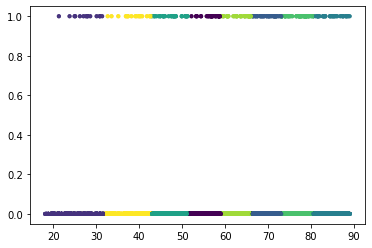

In [51]:
fig, ax = plt.subplots()
ax.scatter(df_select.iloc[:, 0],  # df_select[::10000, 0]
           df_select.iloc[:, 1],  #df_select[::10000, 1]
           marker = ".",
           c = dask_kmeans.labels_,  # dask_kmeans.labels_[::10000],  # dask_kmeans.labels_[::10000]
           cmap = 'viridis', 
           alpha = 0.25);

In [104]:
ddf

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,HCO3,FiO2,pH,PaCO2,SaO2,AST,BUN,Alkalinephos,Calcium,Chloride,Creatinine,Bilirubin_direct,Glucose,Lactate,Magnesium,Phosphate,Potassium,Bilirubin_total,TroponinI,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel
npartitions=999,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,int64,int64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [ ]:
# https://ml.dask.org/modules/generated/dask_ml.decomposition.PCA.html#dask_ml.decomposition.PCA

pca = dask_ml.decomposition.PCA(n_components = 5, svd_solver = "auto")
pca.fit(ddf.to_dask_array(lengths = True))
# pca.fit(ddf)
# dask.dataframe.from_pandas(df[:100_000].reset_index())

In [ ]:
pca

In [ ]:
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

## Dimension Reduction

In [ ]:
## %pip install scikit-learn==0.24.1
# %pip install umap-learn # ==0.5.1
# %pip install trimap # ==1.0.15
%pip install pacmap # ==0.3

In [ ]:
import pathlib
import time
import sklearn
import trimap
import umap
import pacmap
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np


dftemp = df
# dftemp = df.groupby(["Sepsis"]).mean()
# dftemp = df.groupby(level = 0).agg(["max"])
# dftemp = df.groupby(level = 0).mean()

dftemp = df.groupby(level = 0).tail(1) #.groupby(["Sepsis"]).agg(["max"])
# dftemp = df.groupby(level = 0).head(1) #.groupby(["Sepsis"]).agg(["max"])
# dftemp = df.groupby(level = 0).mean() #.groupby(["Sepsis"]).agg(["max"])

# dftemp = dftemp[:1000]
dftemp = dftemp.fillna(0)
dftemp

In [ ]:
basedir = "dimredu_mean"
basedir = "dimredu_head"
basedir = "dimredu_tail"
pathlib.Path(basedir).mkdir(exist_ok = True)

# Algorithms to test

algorithms = {
    # 't-SNE': sklearn.manifold.TSNE(),
    'UMAP': umap.UMAP(),
    'TriMAP': trimap.TRIMAP(),
    'PaCMAP': pacmap.PaCMAP(),
}

# Create embeddings for each algorithm & save fitting time
results = {}
for name, algorithm in algorithms.items():
    print("Computing:", name)

    # Calculate embeddings
    t0 = time.time()
    # embedding = algorithm.fit_transform(dftemp.values.drop(["SepsisLabel", "Sepsis"]))
    embedding = algorithm.fit_transform(dftemp.drop(columns = ["SepsisLabel", "Sepsis"]).values)

    # Store results & runtime
    results[name] = {
        'embedding': pd.DataFrame(embedding, columns = [f'{basedir}_{name}_x', f'{basedir}_{name}_y']),
        'time': time.time() - t0
    }

    np.save(f'{basedir}/{name}.npy', embedding, allow_pickle = False)
    np.savetxt(f'{basedir}/{name}.npy.txt', embedding)
    # np.savez(f'{basedir}/{name}.npz', **{name: embedding})
    np.savez_compressed(f'{basedir}/{name}.npz', **{name: embedding})

In [ ]:
pd.concat([v["embedding"] for v in results.values()], names = results.keys(), axis = 1)

In [ ]:
pd.concat(
    [
        # df.groupby(level = 0).mean(),
        # df.groupby(level = 0).head(1).reset_index(level = 1, drop = True),
        df.groupby(level = 0).tail(1).reset_index(level = 1, drop = True),
        pd.concat([v["embedding"] for v in results.values()], names = results.keys(), axis = 1)
    ],
    axis = 1).plot.scatter(
        # x = f"{basedir}_PaCMAP_x", y = f"{basedir}_PaCMAP_y",
        x = f"{basedir}_UMAP_x",
        y = f"{basedir}_UMAP_y",
        # x = f"{basedir}_TriMAP_x", y = f"{basedir}_TriMAP_y",
        c = "SepsisLabel",
        # c = "Sepsis",
        cmap = plt.cm.cool,
        alpha = .5,
        marker = ".",
    )
plt.title(k)
plt.gcf().set_size_inches(15, 10)
plt.show()

# playground